In [95]:
import os
from collections import defaultdict #dict subclass that calls a factory function to supply missing values
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Table of contents
- 0: Goal Definition
- 1: Data Acquisition
- 2: Data Exploration
- 3: Preprocessing
- 4: Processing
- 5: Validation

## 0: Objective

Microsoft Portable Executable (PE) files are a common target for malware authors due to their widespread use in Windows operating systems. 
These files, which can be executables, object code, or DLLs, contain metadata within their headers that can provide extensive information about their behavior and potential maliciousness.
Identifying potential threats among these files using header information is a way to speed up static file analysis by reducing the overhead involved in data collection and processing.
This project will explore the effectiveness of different models in discriminating between malicious and benign PE files.

## 1: Data Acquisition

The dataset was taken from a kaggle repository [[1](#reference-section-1)].

The dataset was generated using a python script for PE header analysis [[2](#reference-section-2)].

## 2: Data Exploration

In [96]:
file = open('dataset/ClaMP_Integrated-5184.csv')
df = pd.read_csv(file, skip_blank_lines=True, na_filter=False, encoding='utf-8')

In [97]:
df.isnull().sum()

e_cblp        0
e_cp          0
e_cparhdr     0
e_maxalloc    0
e_sp          0
             ..
E_data        0
filesize      0
E_file        0
fileinfo      0
class         0
Length: 70, dtype: int64

There are no `null` features

### 2.1: Feature explaination

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5210 entries, 0 to 5209
Data columns (total 70 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   e_cblp                       5210 non-null   int64  
 1   e_cp                         5210 non-null   int64  
 2   e_cparhdr                    5210 non-null   int64  
 3   e_maxalloc                   5210 non-null   int64  
 4   e_sp                         5210 non-null   int64  
 5   e_lfanew                     5210 non-null   int64  
 6   NumberOfSections             5210 non-null   int64  
 7   CreationYear                 5210 non-null   int64  
 8   FH_char0                     5210 non-null   int64  
 9   FH_char1                     5210 non-null   int64  
 10  FH_char2                     5210 non-null   int64  
 11  FH_char3                     5210 non-null   int64  
 12  FH_char4                     5210 non-null   int64  
 13  FH_char5          

The features can be divided in four groups based on the part of the file from which they are derived:    
- Image DOS header:
    - The features whose names are preceded by the lowercase `e` letter
- File header:
    - `NumberOfSections`, `CreationYear` and all of the characteristics flags preceded by `FH`
- Optional header
    - All of the features from `MajorLinkerVersion` to `LoaderFlags`
- Derived features
    - The remaning features are derived from the analyzing the file as a whole
    - The `E` preceding `E_text`,`E_data` and `E_file` stands for entropy

### 2.2: Data Visualization

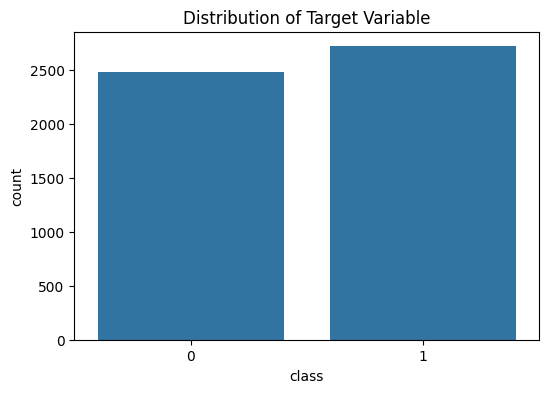

In [99]:
plt.figure(figsize=(6, 4))
sns.countplot(x='class', data=df)
plt.title('Distribution of Target Variable')
plt.show()


The target variable `class`, where 1 indicates that the sample is a malware, is well balanced 

In [100]:
features_to_check = [
    'sus_sections','non_sus_sections','E_file',
    'E_data','E_text','SizeOfImage','SizeOfHeaders',
    'SizeOfInitializedData','SizeOfUninitializedData',
    'SizeOfStackReserve','SizeOfStackCommit',
    'SizeOfHeapReserve','SizeOfHeapCommit'
    ]

We are going to analyze only this subset of features since the others are either binary or pointer addresses

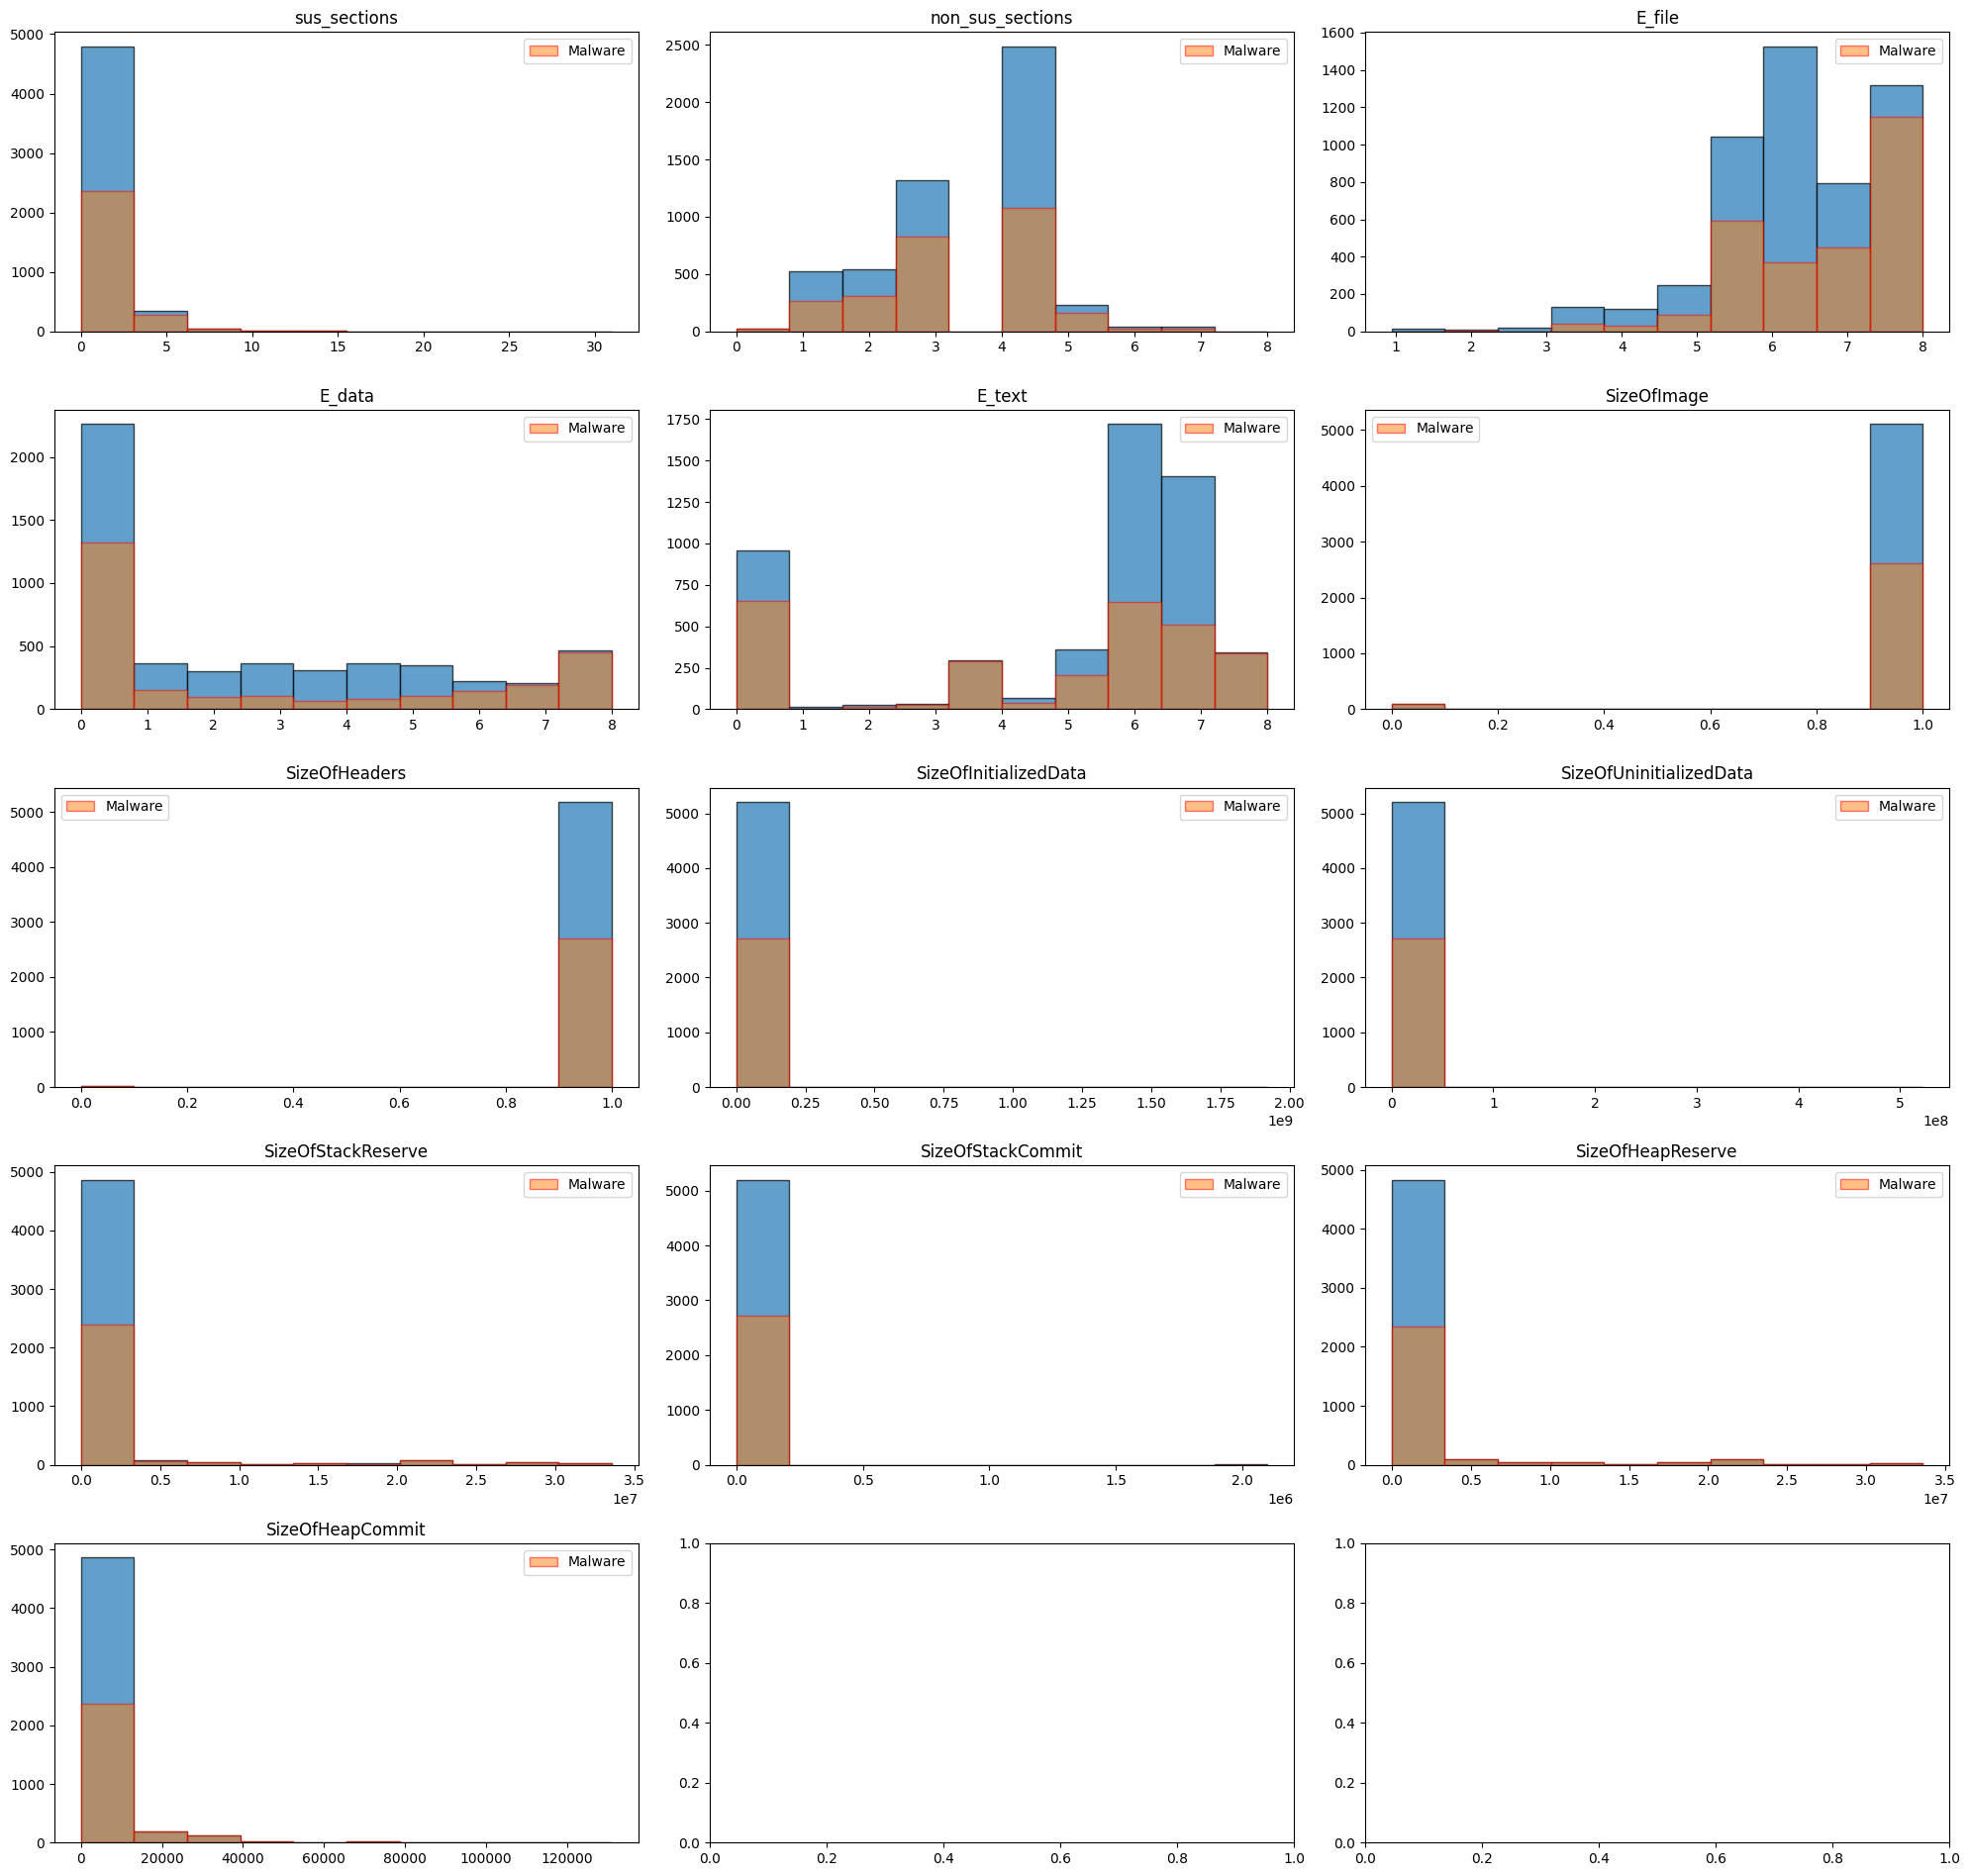

In [101]:
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(len(features_to_check) // 3 + 1, 3, figsize=(20, 20))
axes = axes.flatten()  # Flatten the axes array for easy iteration

for i, feature in enumerate(features_to_check):
    bin_edges = np.histogram_bin_edges(df[feature], bins=10)

    # Plot histogram for all data
    axes[i].hist(df[feature], bins=bin_edges, edgecolor='black', alpha=0.7)

    # Overlay histogram for 'class' == 1
    axes[i].hist(df[df['class'] == 1][feature], bins=bin_edges, edgecolor='red', alpha=0.5, label='Malware')

    # Set title and legend
    axes[i].set_title(feature)
    axes[i].legend()

# Adjust layout and show plot
plt.suptitle('', size=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the suptitle
plt.show()


Since most of the outliers on the features influenced by file size are classified as malware they will not be subject to outlier elimination to not substantially decrease malware recall

In [102]:
features_to_check = [
    'sus_sections','non_sus_sections','E_file',
    'E_data','E_text'
    ]

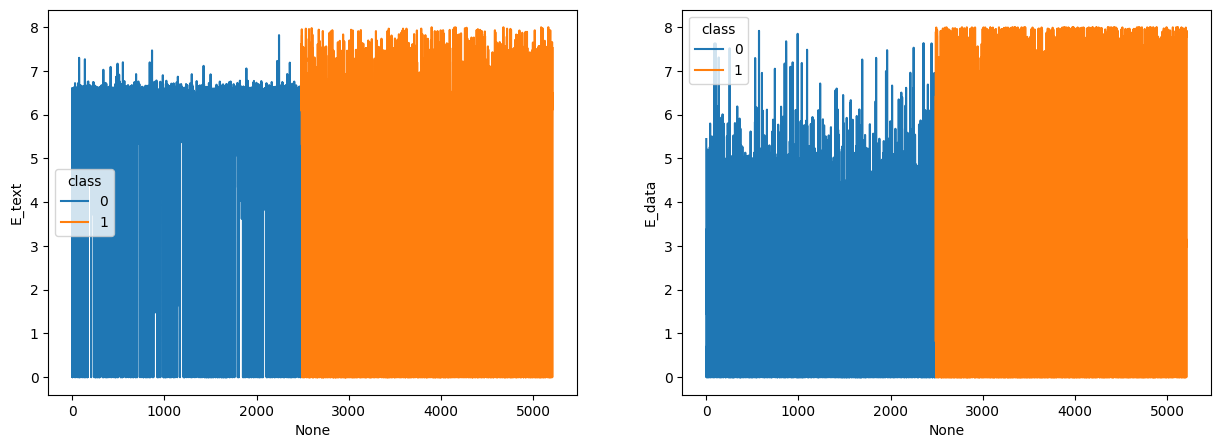

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [103]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

axes = plt.figure(figsize=(10, 6))
axes = sns.lineplot(x=df.index, y='E_text', hue='class', data=df, ax=ax1)

axes =plt.figure(figsize=(10, 6))
axes =sns.lineplot(x=df.index, y='E_data', hue='class', data=df, ax=ax2)

# Show the plot
plt.show()

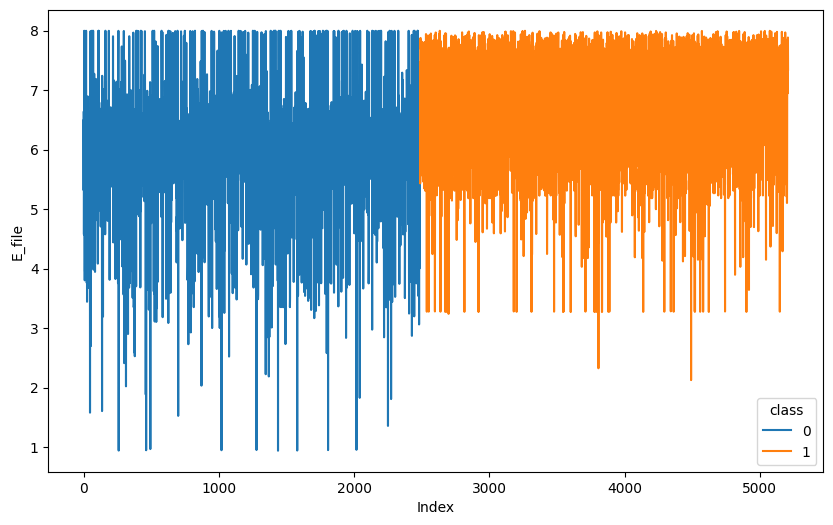

In [104]:
# Create a line plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=df.index, y='E_file', hue='class', data=df)

# Add labels and title
plt.xlabel('Index')
plt.ylabel('E_file')

# Show the plot
plt.show()

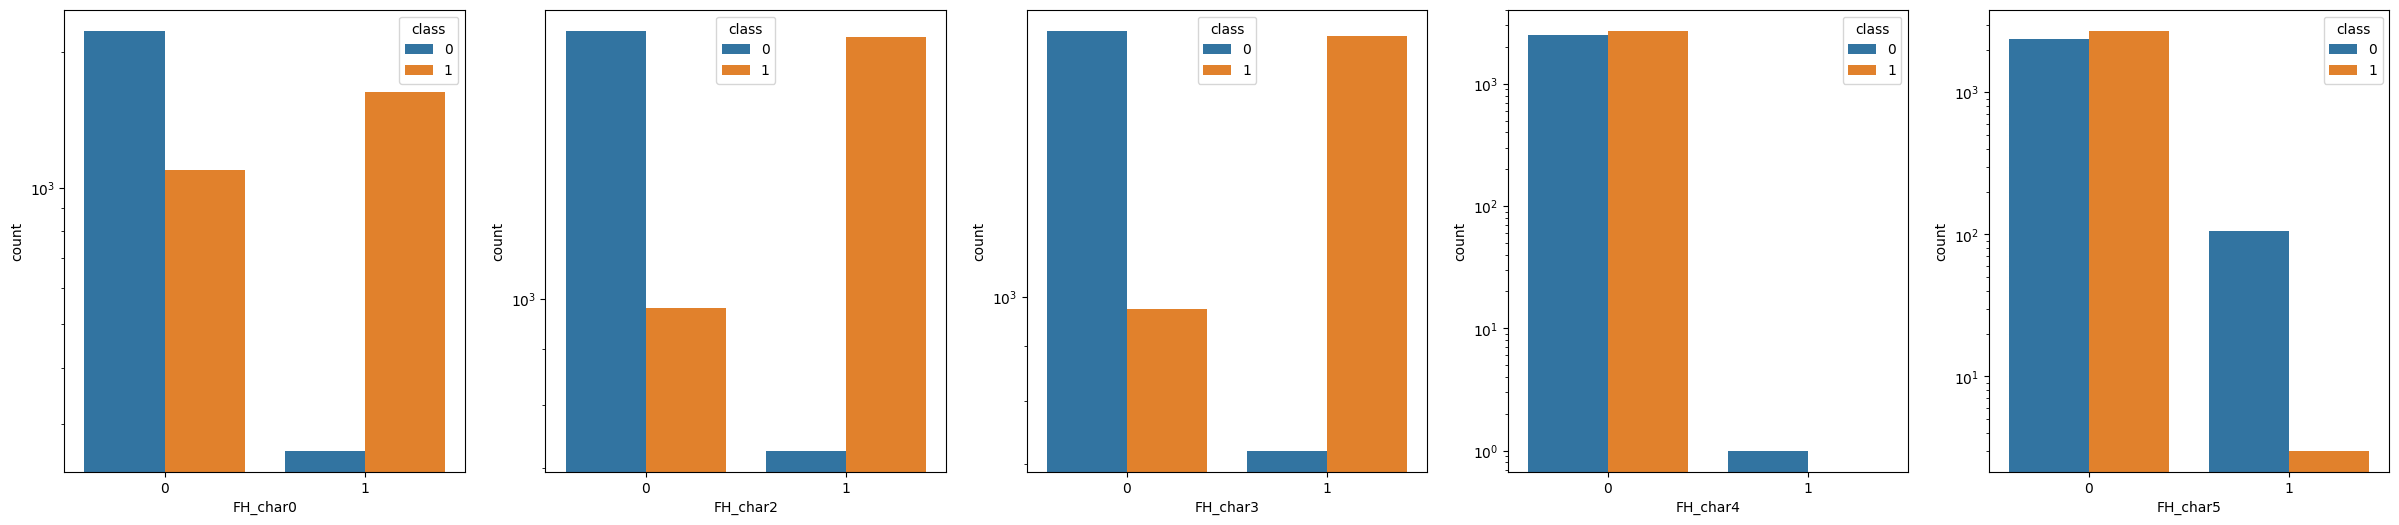

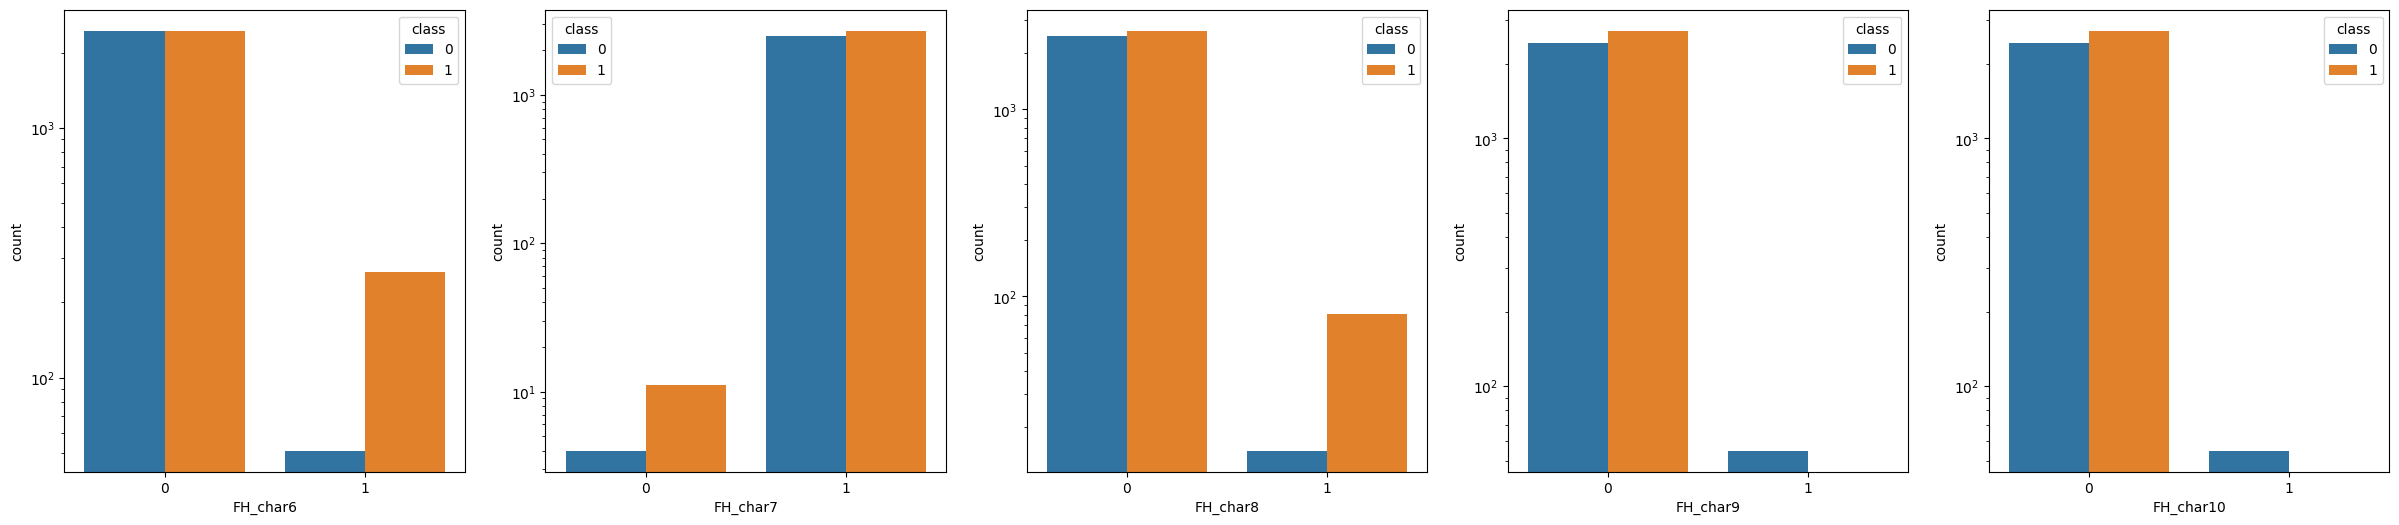

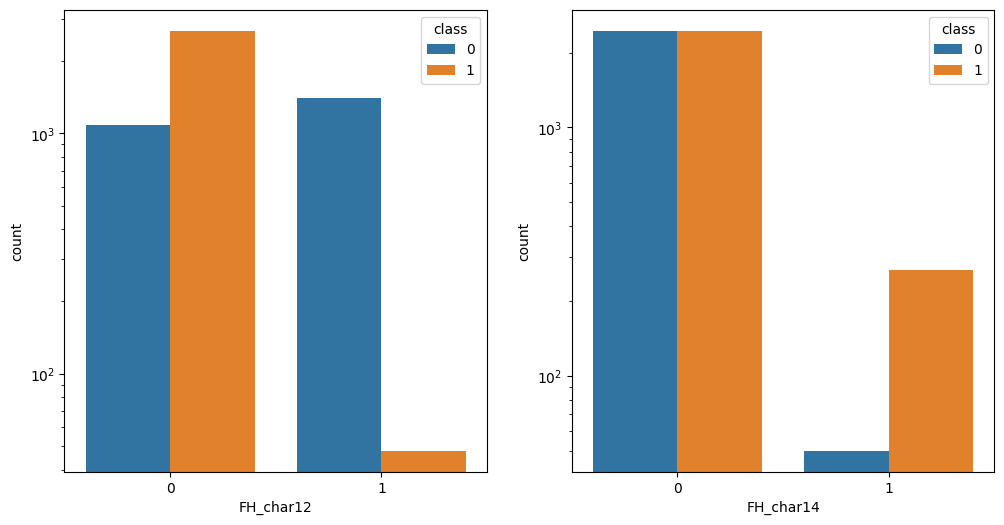

In [105]:
features = [
    'FH_char0', 'FH_char2', 'FH_char3', 
    'FH_char4', 'FH_char5', 'FH_char6', 'FH_char7',
    'FH_char8', 'FH_char9', 'FH_char10',
    'FH_char12', 'FH_char14'
]

nominal_features = df[features]
plots_per_line = 5
for i, column in enumerate(nominal_features.columns):
    if i % plots_per_line == 0:
        r = len(nominal_features.columns) - i
        if r < plots_per_line:
            n_plots = r
        else:
            n_plots = plots_per_line
        _, axs = plt.subplots(1, n_plots, figsize=(6*n_plots, 6))
        plot = 0
    axes = sns.countplot(df, x=column, hue='class', ax=axs[plot])
    axes.set_yscale('log')
    if plot == n_plots-1:
        plt.show()
    plot+=1

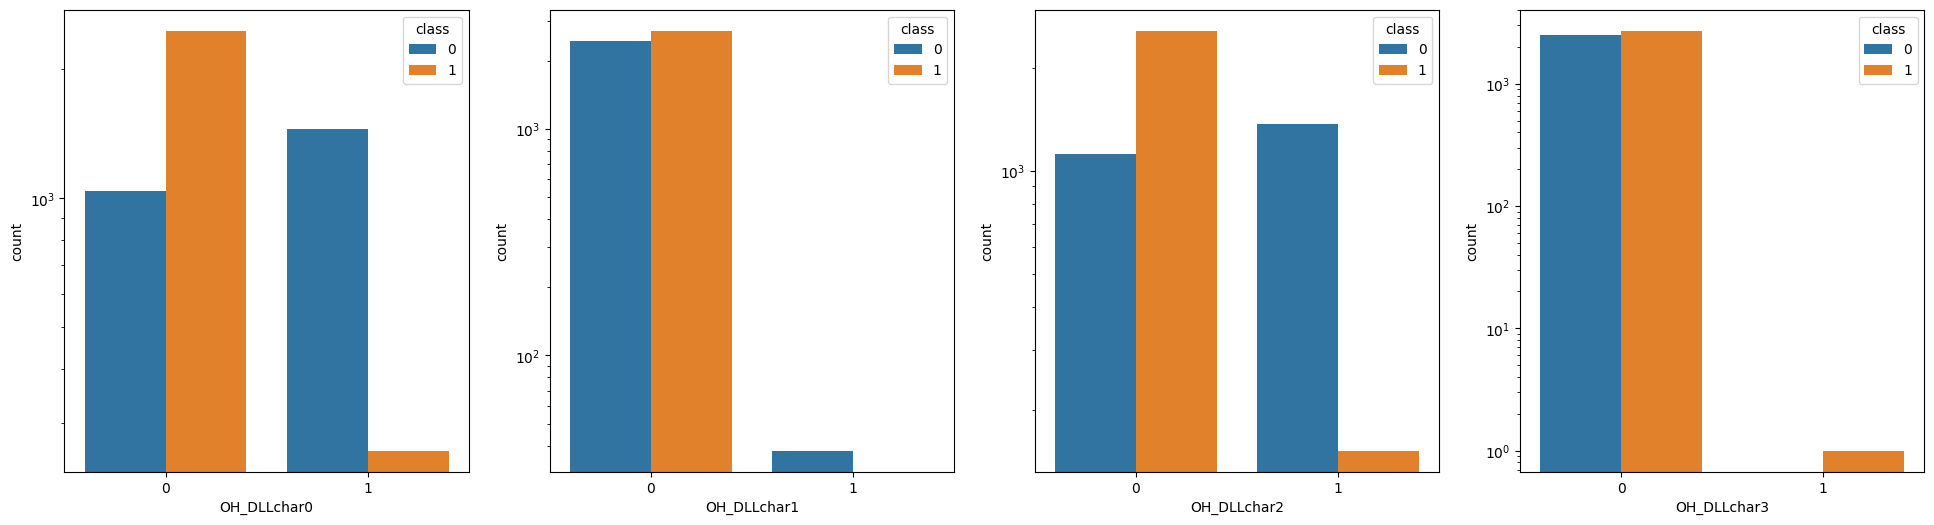

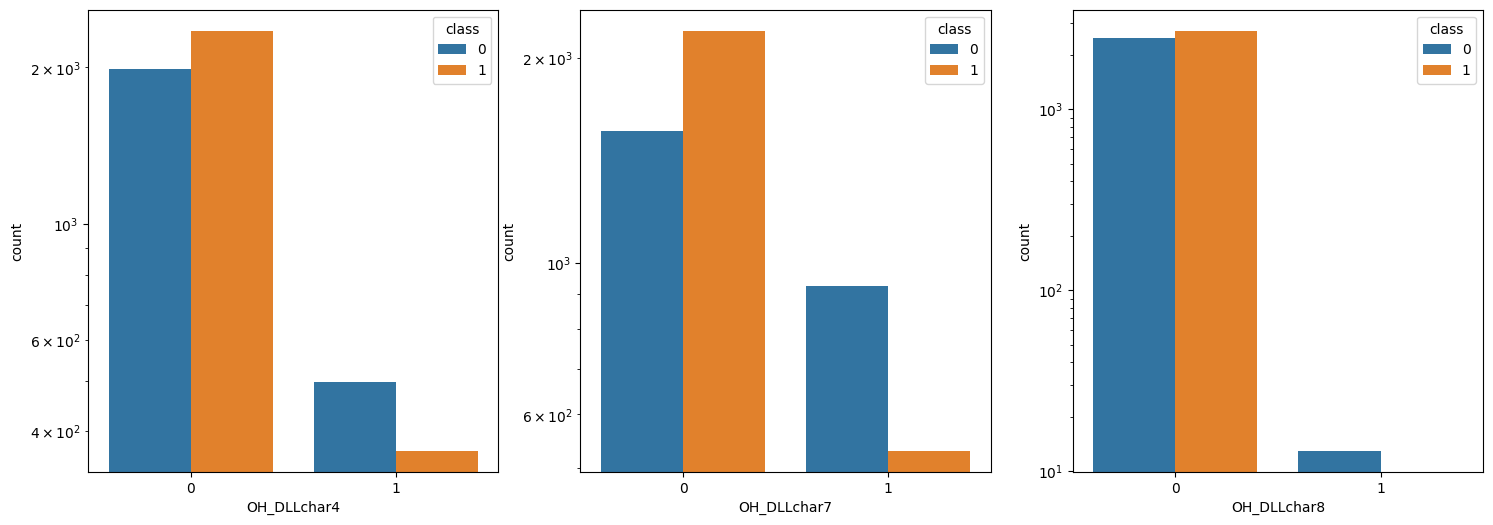

In [106]:
features = [
    'OH_DLLchar0', 'OH_DLLchar1', 'OH_DLLchar2', 'OH_DLLchar3', 
    'OH_DLLchar4', 'OH_DLLchar7',
    'OH_DLLchar8'
]

nominal_features = df[features]
plots_per_line = 4
for i, column in enumerate(nominal_features.columns):
    if i % plots_per_line == 0:
        r = len(nominal_features.columns) - i
        if r < plots_per_line:
            n_plots = r
        else:
            n_plots = plots_per_line
        _, axs = plt.subplots(1, n_plots, figsize=(6*n_plots, 6))
        plot = 0
    axes = sns.countplot(df, x=column, hue='class', ax=axs[plot])
    axes.set_yscale('log')
    if plot == n_plots-1:
        plt.show()
    plot+=1

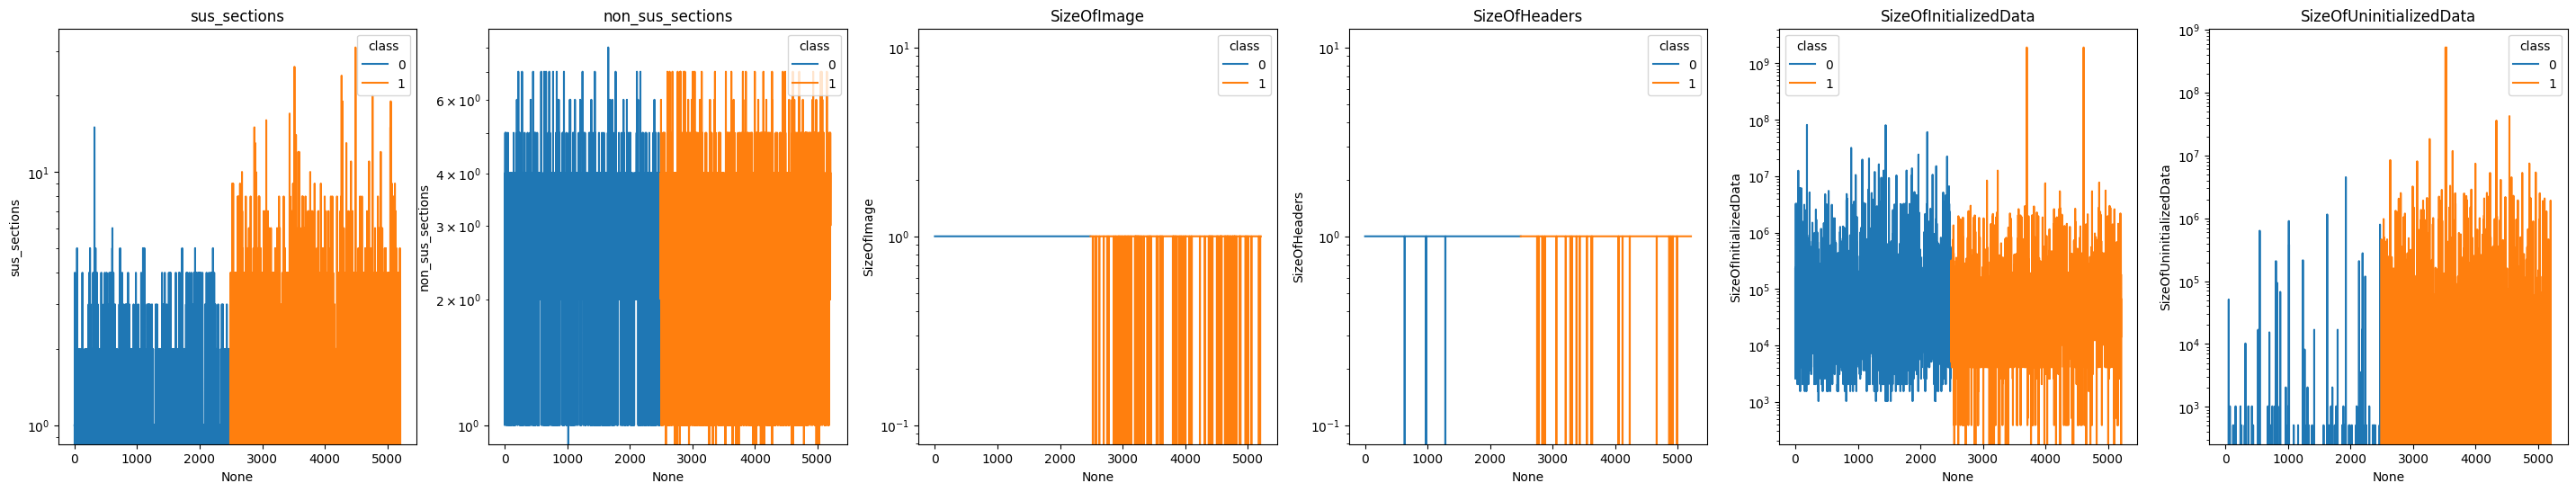

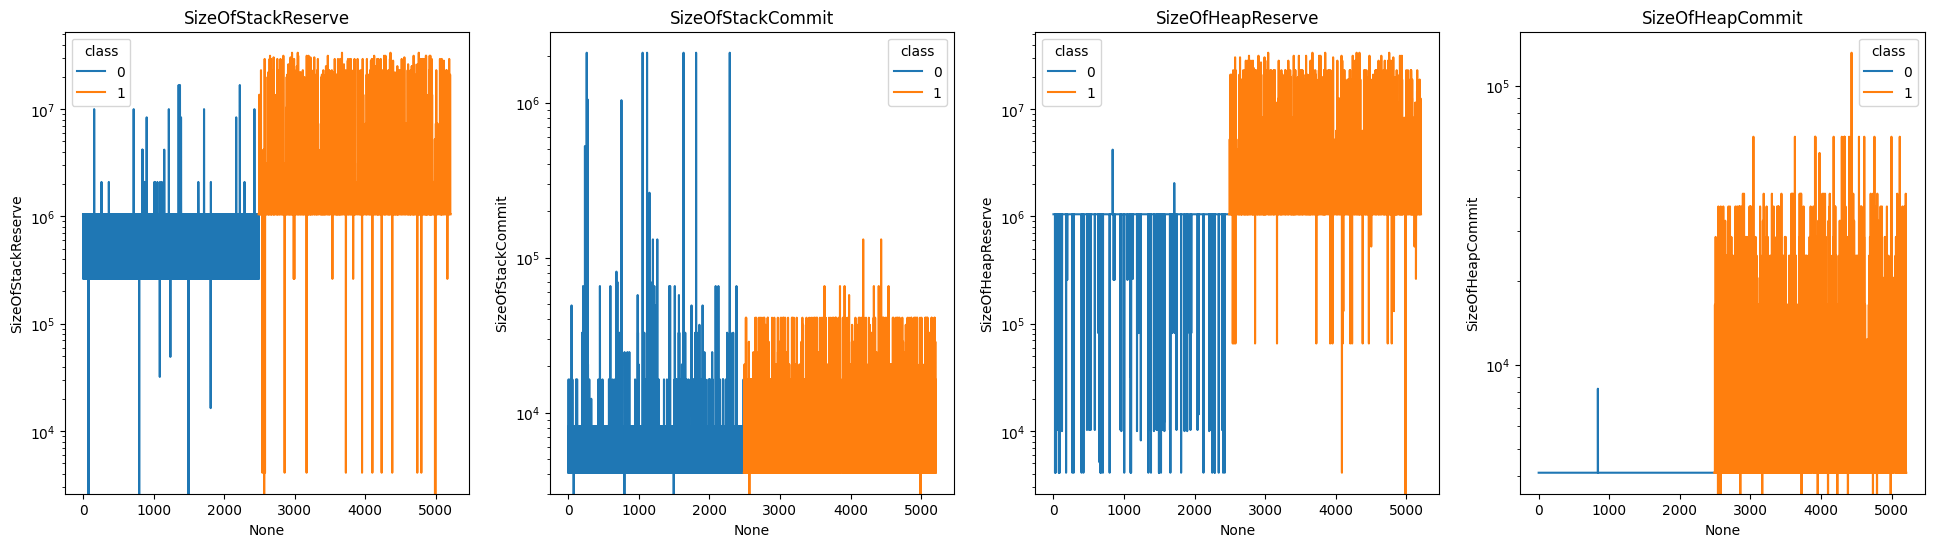

In [107]:
features = [
    'sus_sections','non_sus_sections','SizeOfImage','SizeOfHeaders',
    'SizeOfInitializedData','SizeOfUninitializedData',
    'SizeOfStackReserve','SizeOfStackCommit',
    'SizeOfHeapReserve','SizeOfHeapCommit'
]

other_features = df[features]

plots_per_line = 6
for i, column in enumerate(other_features.columns):
    if i % plots_per_line == 0:
        r = len(other_features.columns) - i
        if r < plots_per_line:
            n_plots = r
        else:
            n_plots = plots_per_line
        _, axs = plt.subplots(1, n_plots, figsize=(6*n_plots, 6))
        plot = 0
    axes = sns.lineplot(df, x=df.index, y=column, hue='class', ax=axs[plot])
    axes.set_title(column)
    axes.set_yscale('log')
    if plot == n_plots-1:
        plt.show()
    plot+=1

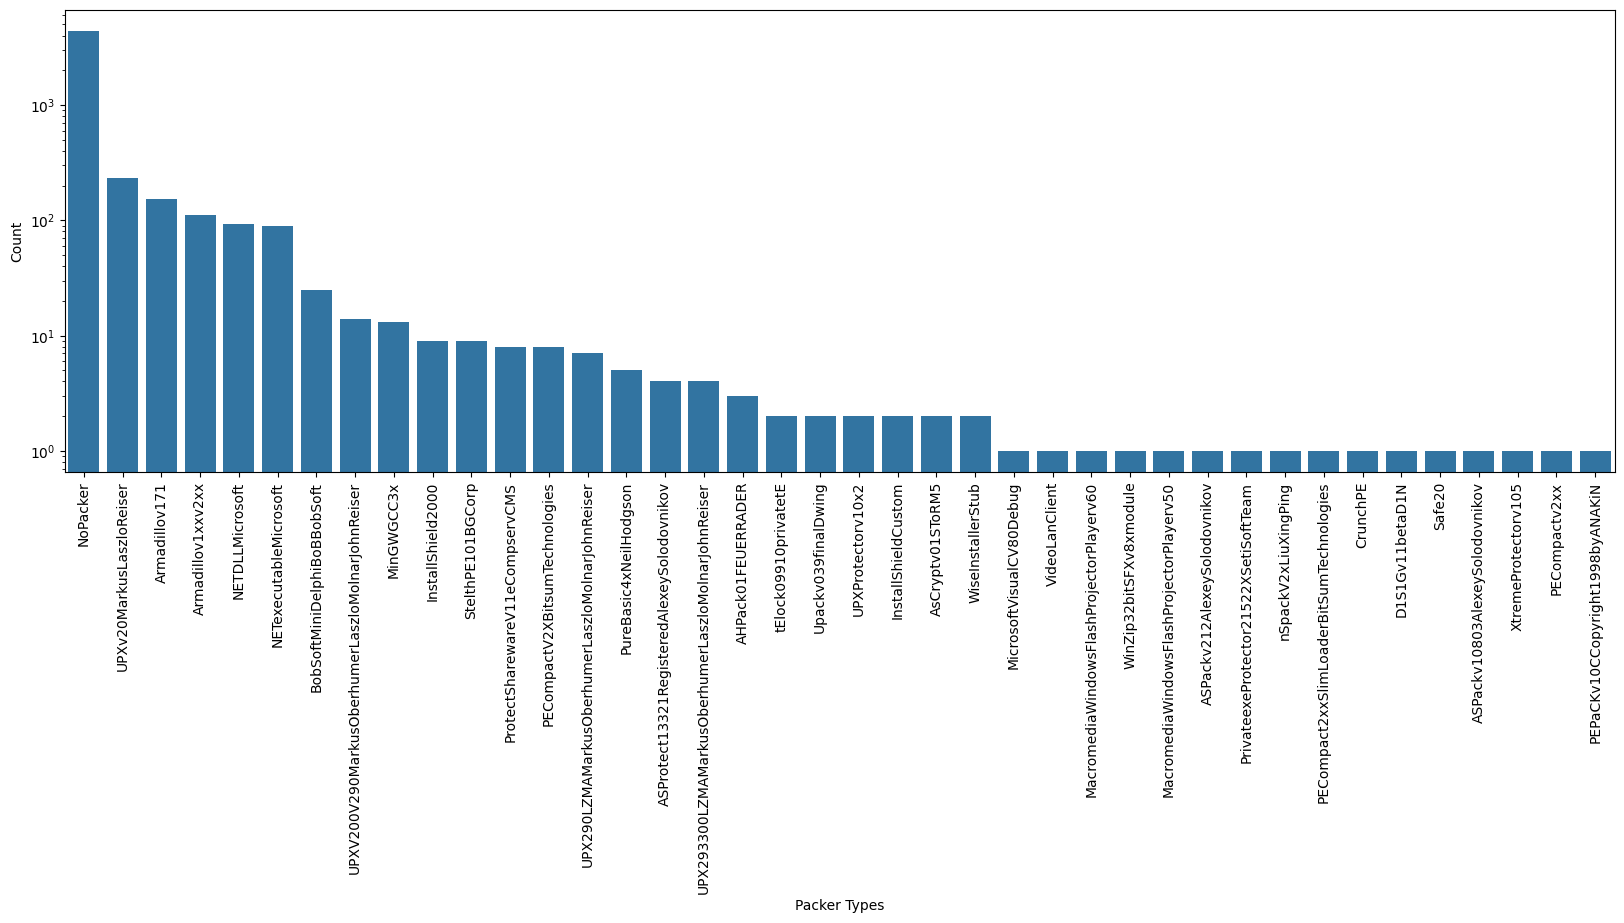

In [108]:
plt.figure(figsize=(20, 6))
axes = sns.countplot(df, x='packer_type', order=df['packer_type'].value_counts().index)
axes.set_yscale('log')
axes.set_xlabel('Packer Types')
axes.set_ylabel('Count')
plt.xticks(rotation='vertical')
plt.show()

The packer_type feature has a relatively high cardinality and has mostly an empty value of "NoPacker", to convert it to an usable value one-hot encoding is used, keeping in mind however that there must be a feature reduction step to prune the features generated by this step.

In [109]:
from sklearn.preprocessing import OneHotEncoder

""" ohe = OneHotEncoder()
raw_new_data = ohe.fit_transform(df[['packer_type']]).astype(int).toarray()
new_feature_names = ohe.get_feature_names_out(['packer_type'])

encoded_data = pd.DataFrame(raw_new_data, columns=new_feature_names)

encoded_data.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

df = pd.concat([df.drop(columns=['packer_type']), encoded_data], axis=1) """

df = df.drop(columns=['packer_type'])
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5210 entries, 0 to 5209
Data columns (total 69 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   e_cblp                       5210 non-null   int64  
 1   e_cp                         5210 non-null   int64  
 2   e_cparhdr                    5210 non-null   int64  
 3   e_maxalloc                   5210 non-null   int64  
 4   e_sp                         5210 non-null   int64  
 5   e_lfanew                     5210 non-null   int64  
 6   NumberOfSections             5210 non-null   int64  
 7   CreationYear                 5210 non-null   int64  
 8   FH_char0                     5210 non-null   int64  
 9   FH_char1                     5210 non-null   int64  
 10  FH_char2                     5210 non-null   int64  
 11  FH_char3                     5210 non-null   int64  
 12  FH_char4                     5210 non-null   int64  
 13  FH_char5          

## 3: Data Preprocessing

In [110]:
from sklearn.model_selection import train_test_split

X = df.drop(['class'], axis=1)
Y = df['class']

train_x, test_x, train_y, test_y = train_test_split(
    X,Y,
    test_size=0.20,  
    random_state=342)

print(train_x.shape)
print(test_x.shape)


(4168, 68)
(1042, 68)


The dataset is split into training and test sets with an 80/20 split

### 2.1: Constant feature elimination


In [118]:

constant_columns = [col for col in train_x.columns if train_x[col].nunique() == 1]

# Drop those constant columns from the DataFrame
train_x_proc = train_x

train_x_proc.drop(columns=constant_columns)

train_y_proc = train_y

train_x_proc.shape

(4168, 68)

Features with only one value are removed from the training set

### 2.2: Outlier elimination

In [124]:
from sklearn.neighbors import LocalOutlierFactor

LOF = LocalOutlierFactor()

outliers_lof = LOF.fit_predict(train_x_proc)

# Add predictions to DataFrame
#train_x_proc_rem = train_x_proc[outliers_lof == 1]

train_x_proc.shape

(4168, 68)

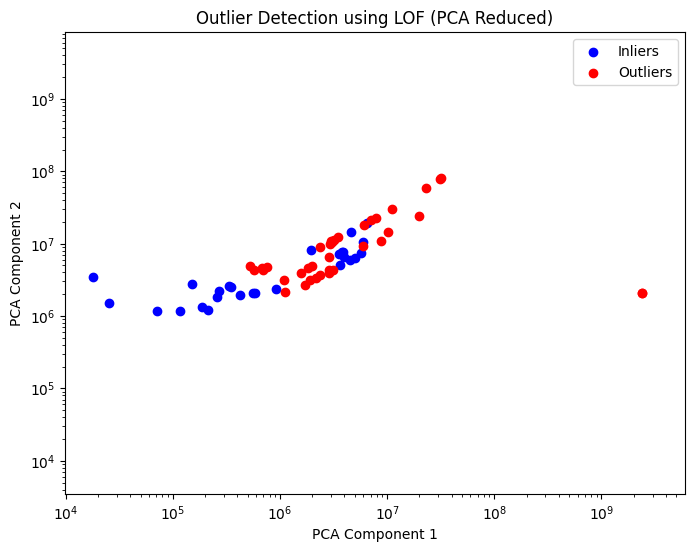

In [125]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df_reduced = pca.fit_transform(train_x_proc)

# Plotting
plt.figure(figsize=(8, 6))

# Plot inliers
plt.scatter(df_reduced[outliers_lof == 1][:, 0], df_reduced[outliers_lof == 1][:, 1], 
            color='blue', label='Inliers')

# Plot outliers
plt.scatter(df_reduced[outliers_lof == -1][:, 0], df_reduced[outliers_lof == -1][:, 1], 
            color='red', label='Outliers')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.yscale('log')
plt.xscale('log')
plt.title('Outlier Detection using LOF (PCA Reduced)')
plt.legend()
plt.show()


In [18]:
""" from scipy.stats import zscore
train_x_proc_o = train_x_proc[features_to_check]
# Calculate Z-scores for each data point
z_scores = zscore(train_x_proc_o.values)
# Define a threshold for identifying outliers
threshold = 3
# Identify outliers
outliers = (z_scores > threshold) | (z_scores < -threshold) """

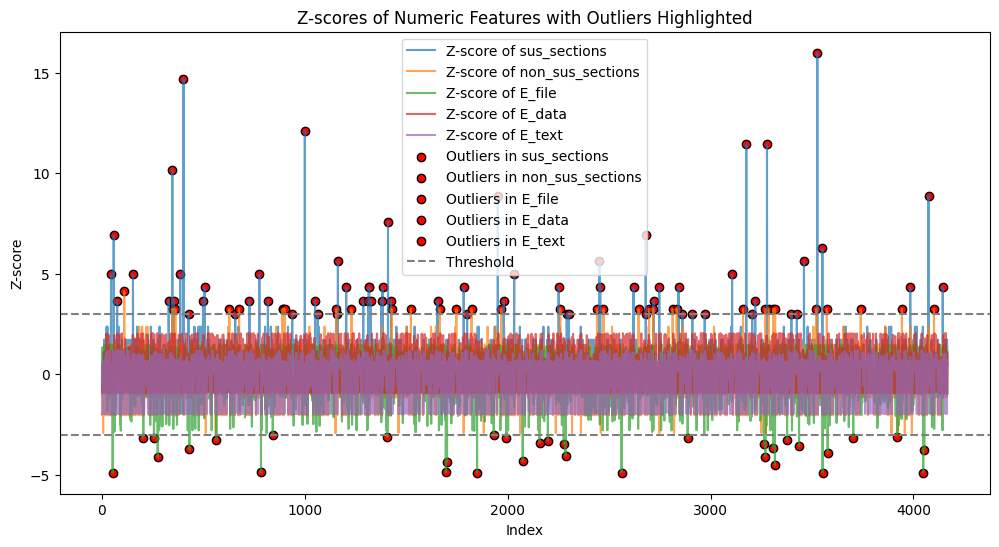

In [19]:
""" fig, ax = plt.subplots(figsize=(12, 6))

# Plot Z-scores for each feature
for i, col in enumerate(train_x_proc_o.columns):
    ax.plot(z_scores[:, i], label=f'Z-score of {col}', alpha=0.7)

# Highlight outliers
for i, col in enumerate(train_x_proc_o.columns):
    outlier_indices = np.where(outliers[:, i])[0]  # Indices where outliers occur
    ax.scatter(outlier_indices, z_scores[outliers[:, i], i], color='red', label=f'Outliers in {col}', edgecolor='black')

# Add horizontal lines for threshold
ax.axhline(threshold, color='grey', linestyle='--', label='Threshold')
ax.axhline(-threshold, color='grey', linestyle='--')

# Add labels and legend
ax.set_xlabel('Index')
ax.set_ylabel('Z-score')
ax.set_title('Z-scores of Numeric Features with Outliers Highlighted')
ax.legend(loc='best')

plt.show() """

In [126]:

# Create a boolean mask where False indicates the presence of an outlier
""" outliers_mask = np.any(outliers, axis=1)

train_x_proc = train_x_proc[~outliers_mask]

train_y_proc = train_y[~outliers_mask] """

train_x_proc = train_x_proc[outliers_lof == 1]
train_y_proc = train_y[outliers_lof == 1]


print(train_x_proc.shape)
train_y_proc.shape

AxisError: axis 1 is out of bounds for array of dimension 1

The `z-score` of the previously selected features is computed for each data-point, the ones exceeding the threshold are then discared

In [21]:
constant_columns = [col for col in train_x_proc.columns if train_x_proc[col].nunique() == 1]

# Drop those constant columns from the DataFrame
train_x_proc = train_x_proc.drop(columns=constant_columns)

train_x_proc.shape

(4036, 60)

The training set is once again checked for constant features, if they are found they are dropped

### 2.3: Correlation Analysis

In [22]:
train_full = pd.concat([train_x_proc, train_y_proc], axis=1)

train_full.shape

(4036, 61)

In [23]:
corr_matrix = train_full.corr(method='pearson').round(2)

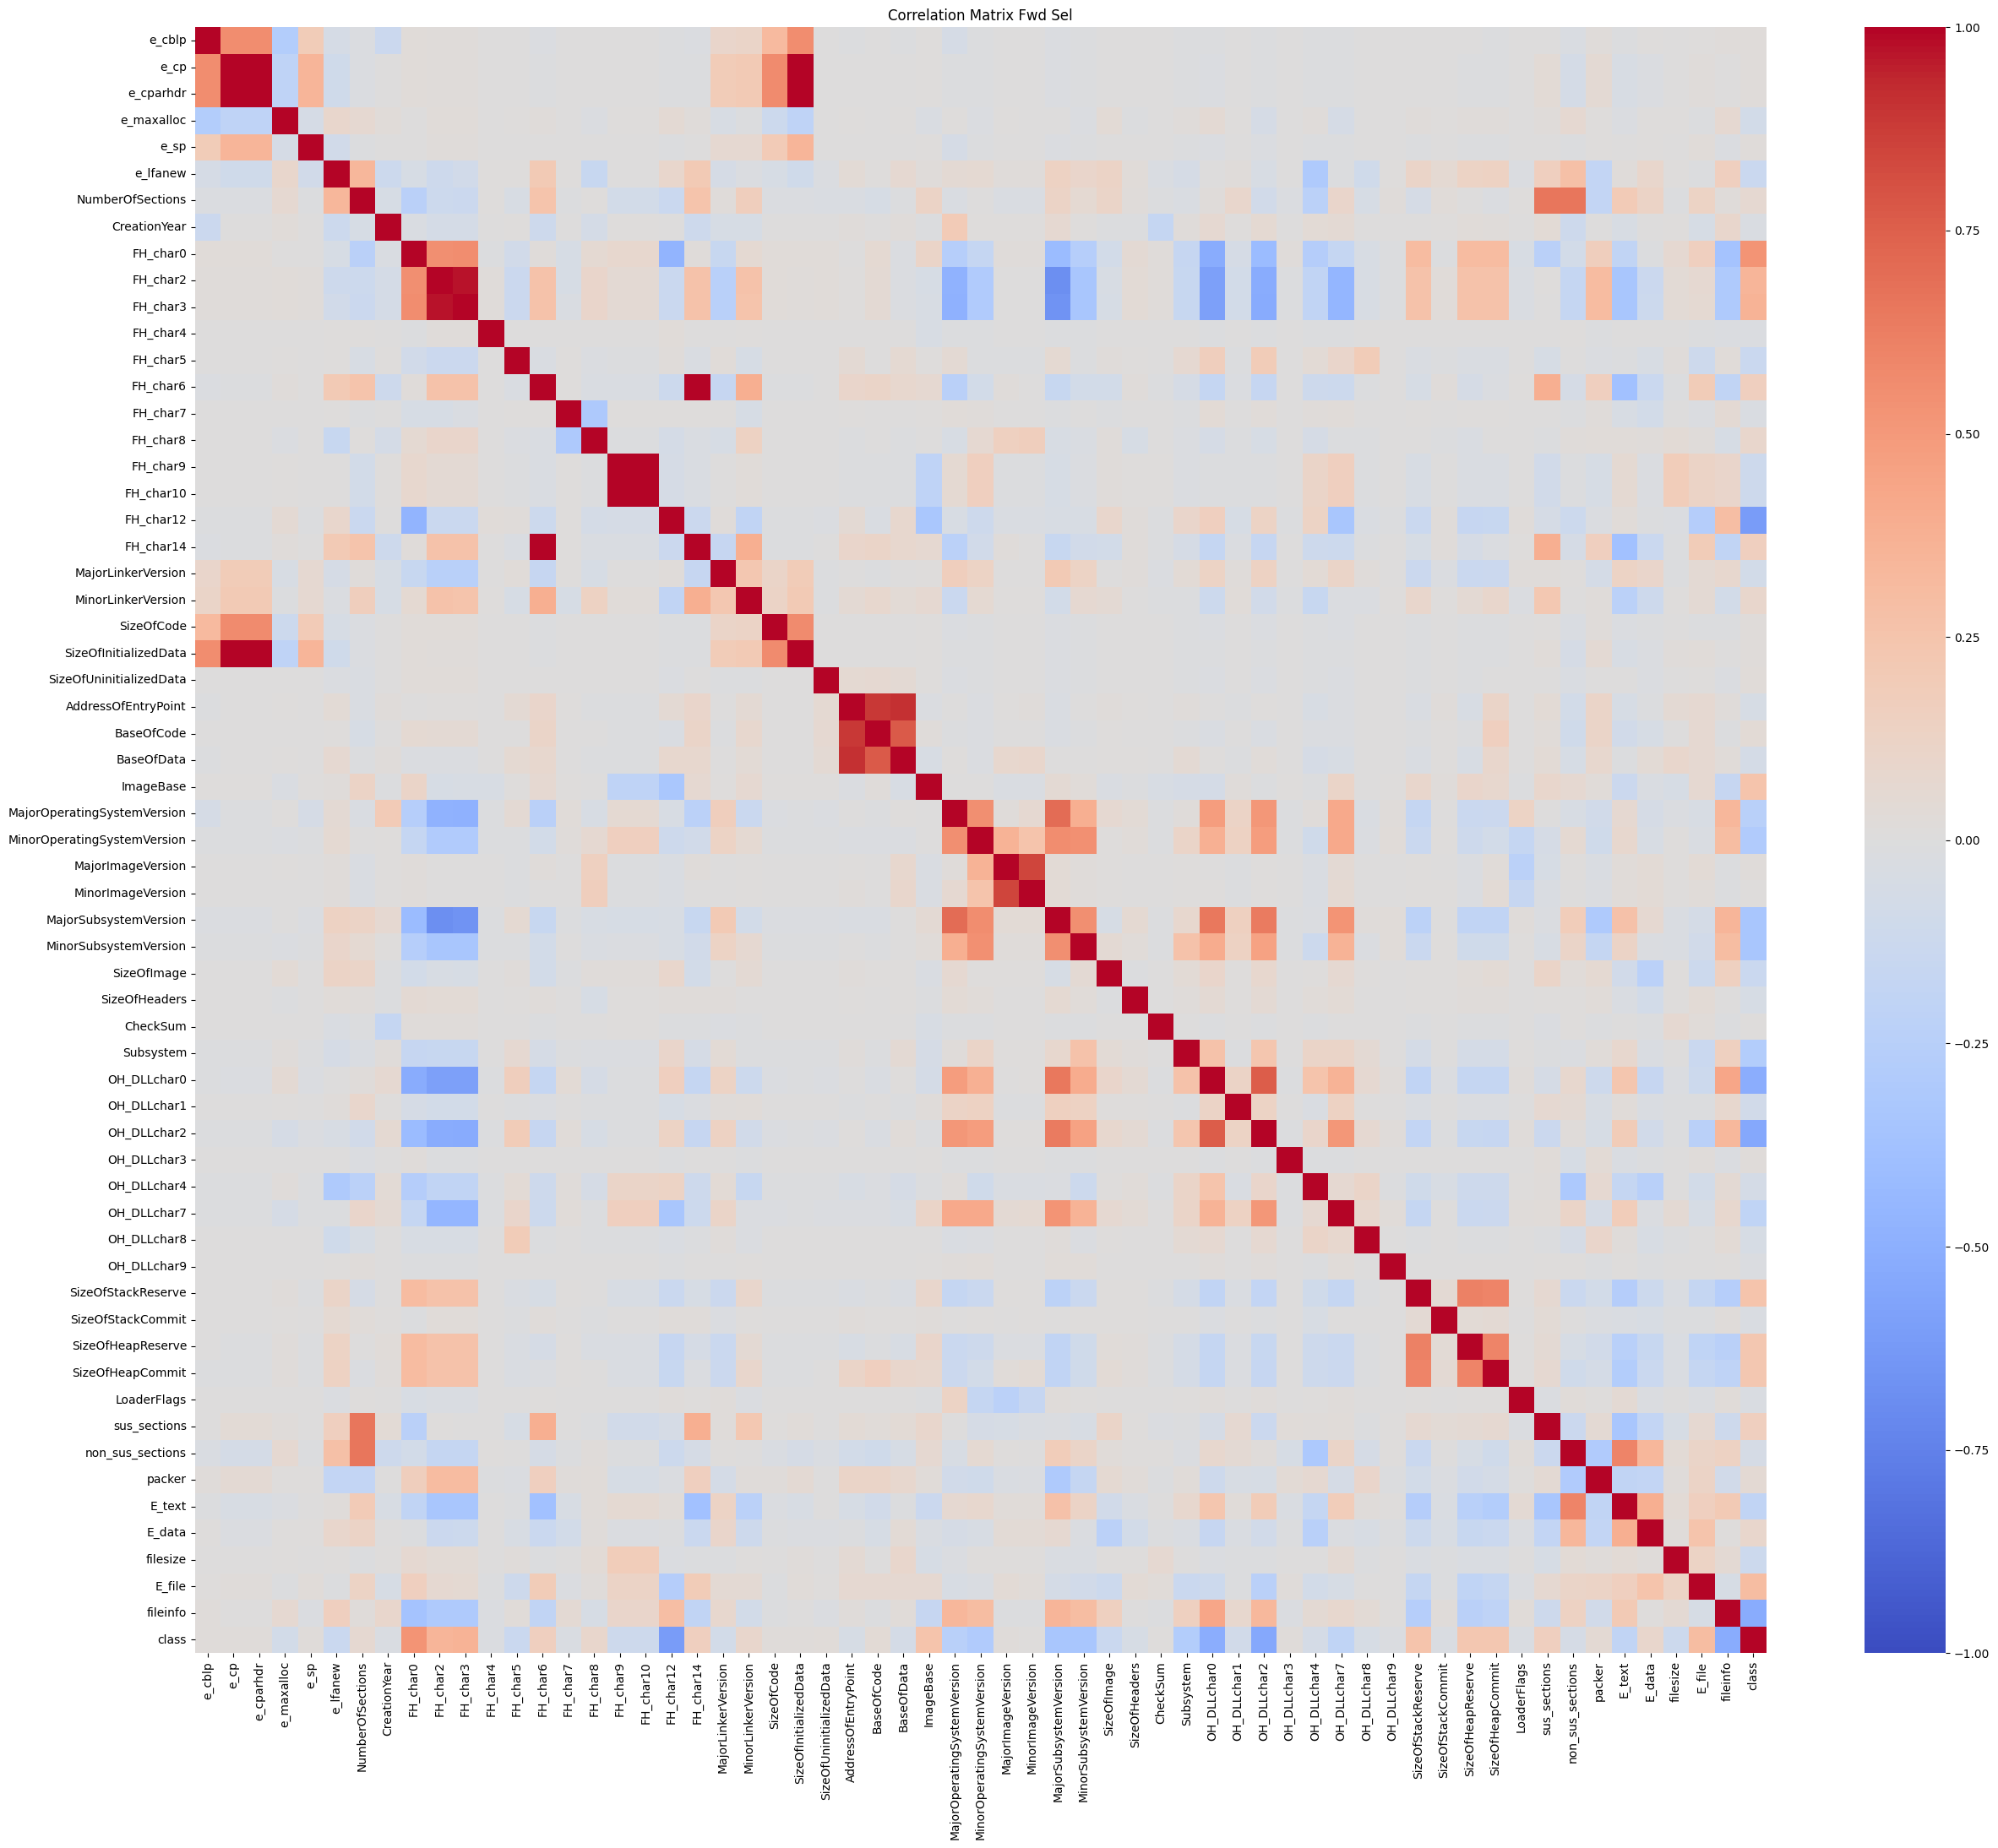

In [24]:
plt.figure(figsize=(30, 25))
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Fwd Sel')
plt.show()

The heatmap shows many features correlated with each other but also many features weakly correlated with the target variable

In [25]:
correlation_with_class = corr_matrix['class'].abs()
selected_features = correlation_with_class[correlation_with_class >= 0.1].index

# Step 3: Update the dataset by retaining only the selected features
train_full_filtered = train_full[selected_features]

The features with a very weak correlation to the target variable are dropped

### 2.4: Feature Selection

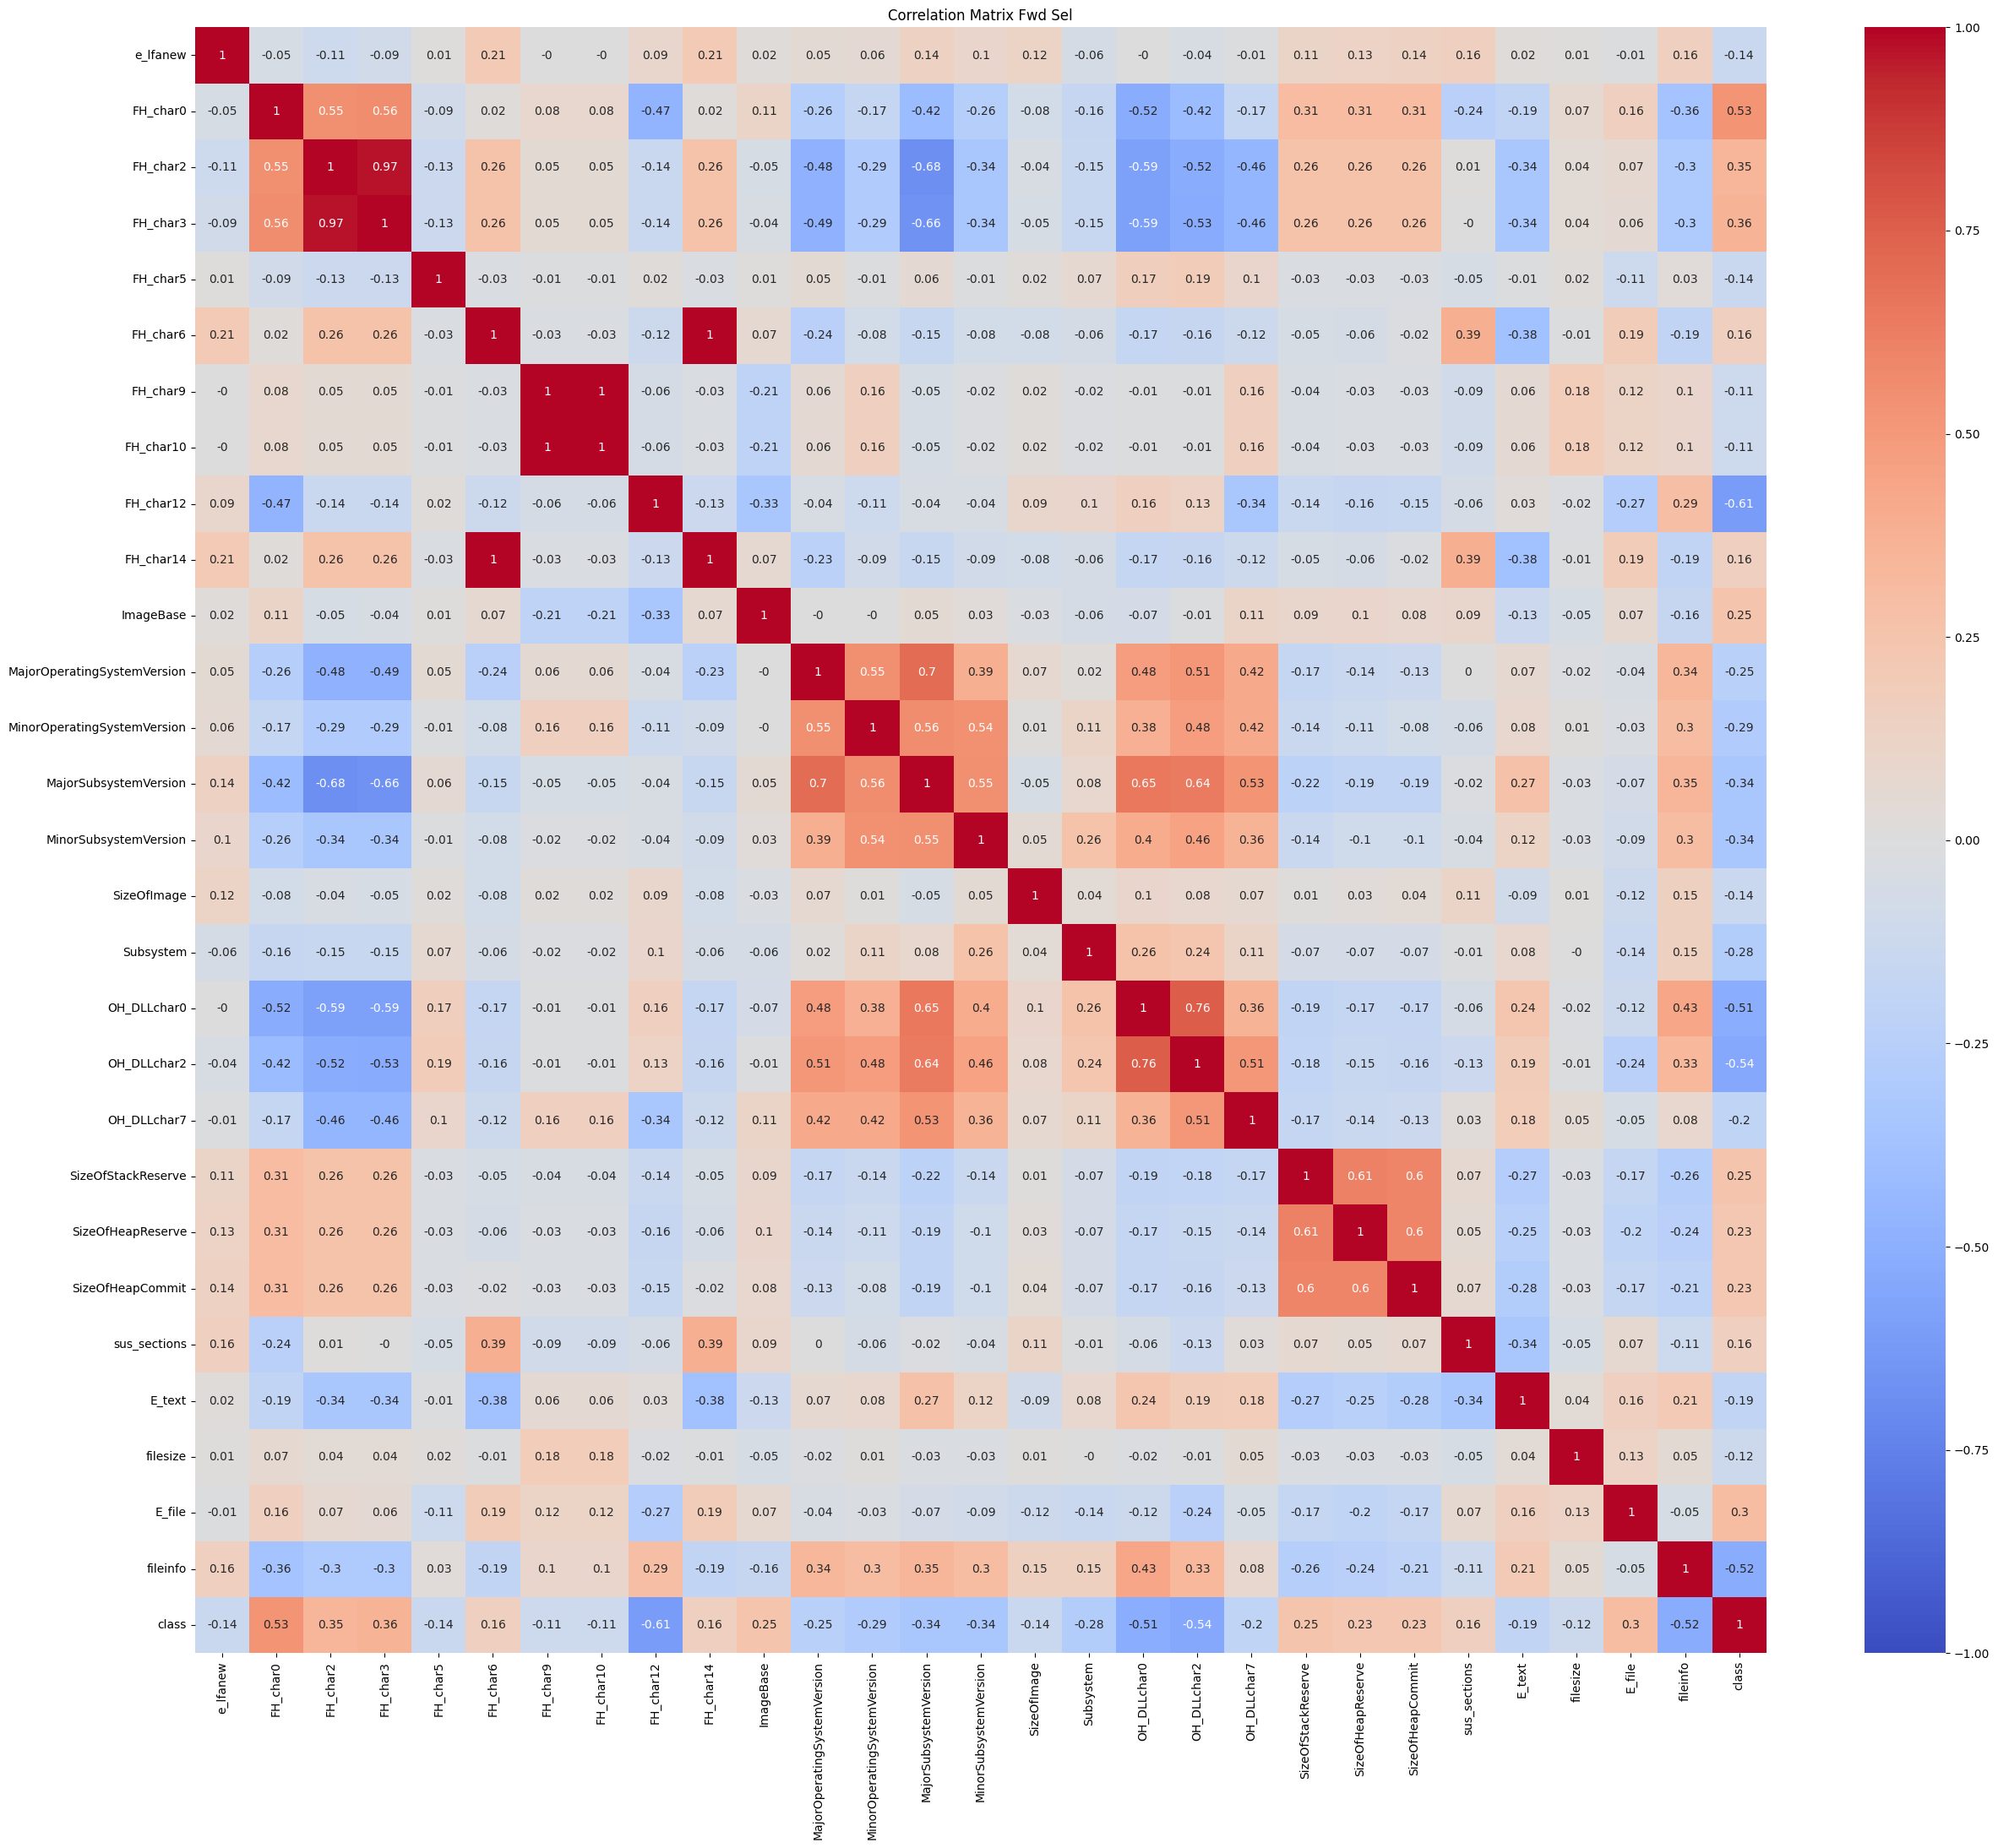

In [26]:
corr_matrix = train_full_filtered.corr(method='pearson').round(2)

plt.figure(figsize=(30,25))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Fwd Sel')
plt.show()

From this correlation matrix of the remaining features it is apparent that there is still a sizeable number of higly correlated features.
Using chi-squared as a metric we will decide which ones will be dropped.

In [27]:
train_x_filtered = train_full_filtered.drop(columns=['class'])

In [28]:
from scipy.stats import chi2_contingency

def compute_chi2(candidates):
    for c in candidates:
        contingency_table = pd.crosstab(train_full_filtered[c], train_full_filtered['class'])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        print(f"Feature {c}: Chi-Square={chi2}, P-Value={p}, Degrees-Of-Freedom={dof}")

to_remove = []

#### Correlated features: FH_char0, FH_char2, FH_char3


In [29]:

candidates = ['FH_char0', 'FH_char2', 'FH_char3']
compute_chi2(candidates)


Feature FH_char0: Chi-Square=1124.7141499503086, P-Value=1.4042976785960744e-246, Degrees-Of-Freedom=1
Feature FH_char2: Chi-Square=490.8750320120096, P-Value=9.19211528847087e-109, Degrees-Of-Freedom=1
Feature FH_char3: Chi-Square=507.44454483448277, P-Value=2.2814515510201313e-112, Degrees-Of-Freedom=1


These three values correpsond to different file header flags:
- `FH_char0` -> `IMAGE_FILE_RELOCS_STRIPPED`
    - The file does not contain base relocations and must therefore be loaded at its preferred base address
- `FH_char2` -> `IMAGE_FILE_LINE_NUMS_STRIPPED`
    - COFF line numbers have been removed
- `FH_char3` -> `IMAGE_FILE_LOCAL_SYMS_STRIPPED`
    - COFF symbol table entries for local symbols have been removed

As we can see from the Chi-Square values the two values `FH_char2` and `FH_char3` are weakly related with the target variable when compared with the `FH_char0` feature.
This is understandable since they both refer to the fact that the debug symbols have been stripped from the executable, a practice common to both malicious and non-malicious software.

These two features will thus be removed.

In [30]:
to_remove += ['FH_char3']

to_remove

['FH_char3']

#### Correlated features: FH_char6, FH_char14


In [31]:
candidates = ['FH_char6','FH_char14']
compute_chi2(candidates)

Feature FH_char6: Chi-Square=97.13951440420666, P-Value=6.46105349849599e-23, Degrees-Of-Freedom=1
Feature FH_char14: Chi-Square=99.87688935751493, P-Value=1.6217059833426167e-23, Degrees-Of-Freedom=1


These two values correpsond to different file header flags:
- `FH_char6` -> `IMAGE_FILE_BYTES_REVERSED_LO `
    - Little endian
- `FH_char14` -> `IMAGE_FILE_BYTES_REVERSED_HI `
    - Big endian

Both of these values are very similar since the flags have an extremely similar function, they are both realtively weakly related with the target variable and will be dropped

In [32]:
to_remove += ['FH_char6','FH_char14']

#### Correlated features: FH_char9, FH_char10


In [33]:
candidates = ['FH_char9', 'FH_char10']
compute_chi2(candidates)

Feature FH_char9: Chi-Square=48.38522544595752, P-Value=3.501967286703346e-12, Degrees-Of-Freedom=1
Feature FH_char10: Chi-Square=48.38522544595752, P-Value=3.501967286703346e-12, Degrees-Of-Freedom=1


- `FH_char9` -> `IMAGE_FILE_REMOVABLE_RUN_ FROM_SWAP  `
    - If the image is on removable media, fully load it and copy it to the swap file. 
- `FH_char10` -> `IMAGE_FILE_NET_RUN_FROM_SWAP  `
    - If the image is on network media, fully load it and copy it to the swap file. 

Both of these features have relatively low chi-square values and relatively high p-values, they will both be dropped.

In [34]:
to_remove += candidates

#### Correlated features: SizeOfStackReserve, SizeOfHeapReserve, SizeOfHeapCommit


In [35]:
candidates = ['SizeOfStackReserve', 'SizeOfHeapReserve','SizeOfHeapCommit']
compute_chi2(candidates)

Feature SizeOfStackReserve: Chi-Square=1095.7471000592482, P-Value=2.977676054832852e-211, Degrees-Of-Freedom=30
Feature SizeOfHeapReserve: Chi-Square=402.9757149916451, P-Value=1.7113527279602063e-61, Degrees-Of-Freedom=40
Feature SizeOfHeapCommit: Chi-Square=315.726536100923, P-Value=1.223149732934923e-59, Degrees-Of-Freedom=13


- `SizeOfStackReserve`
    - Total virtual memory reserved for the stack
- `SizeOfHeapReserve`
    - Total virtual memory reserved for the heap
- `SizeOfHeapCommit`
    - The initial memory allocated for the heap.

All of these values are strongly correlated with the target variable, however `SizeOfStackReserve` will be prioritized over the correlated variables`SizeOfHeapCommit` and `SizeOfHeapReserve` due to the chi-square value

In [36]:
to_remove += ['SizeOfHeapCommit','SizeOfHeapReserve']

#### Correlated features: MajorOperatingSystemVersion, MinorOperatingSystemVersion, MajorSubsystemVersion, MinorSubsystemVersion, OH_DLLchar0, OH_DLLchar2, OH_DLLchar7


In [37]:
candidates = ['MajorOperatingSystemVersion', 'MinorOperatingSystemVersion','MajorSubsystemVersion','MinorSubsystemVersion','OH_DLLchar0','OH_DLLchar2','OH_DLLchar7']
compute_chi2(candidates)

Feature MajorOperatingSystemVersion: Chi-Square=890.7147054060929, P-Value=6.194610114438684e-186, Degrees-Of-Freedom=9
Feature MinorOperatingSystemVersion: Chi-Square=714.3247854886179, P-Value=5.754322886802667e-148, Degrees-Of-Freedom=9
Feature MajorSubsystemVersion: Chi-Square=767.9000205947395, P-Value=6.887054769492506e-165, Degrees-Of-Freedom=4
Feature MinorSubsystemVersion: Chi-Square=688.6112853995864, P-Value=1.0189736712091793e-147, Degrees-Of-Freedom=4
Feature OH_DLLchar0: Chi-Square=1057.3039654426577, P-Value=6.292038887805972e-232, Degrees-Of-Freedom=1
Feature OH_DLLchar2: Chi-Square=1176.9088801565028, P-Value=6.363326860642406e-258, Degrees-Of-Freedom=1
Feature OH_DLLchar7: Chi-Square=164.46866005838677, P-Value=1.1950363687584036e-37, Degrees-Of-Freedom=1


- `OH_DLLchar0` -> `IMAGE_DLLCHARACTERISTICS_HIGH_ENTROPY_VA `
    - Image can handle a high entropy 64-bit virtual address space.  
- `OH_DLLchar2` -> `IMAGE_DLLCHARACTERISTICS_FORCE_INTEGRITY`
    - Code Integrity checks are enforced. 
- `OH_DLLchar7` -> `IMAGE_DLLCHARACTERISTICS_APPCONTAINER `
    - Image must execute in an AppContainer.

`OH_DLLchar7` appears to be relatively weakly related with the target variable, `MinorSubsystemVersion` and `MinorOperatingSystemVersion` will also be dropped to prioritize the correlated features with higher chi-square values.

In [38]:
to_remove += ['OH_DLLchar7','MinorSubsystemVersion','MinorOperatingSystemVersion']

In [39]:
to_remove

['FH_char3',
 'FH_char6',
 'FH_char14',
 'FH_char9',
 'FH_char10',
 'SizeOfHeapCommit',
 'SizeOfHeapReserve',
 'OH_DLLchar7',
 'MinorSubsystemVersion',
 'MinorOperatingSystemVersion']

In [40]:
train_x_filtered = train_x_filtered.drop(columns=to_remove)
train_x_filtered.shape

(4036, 18)

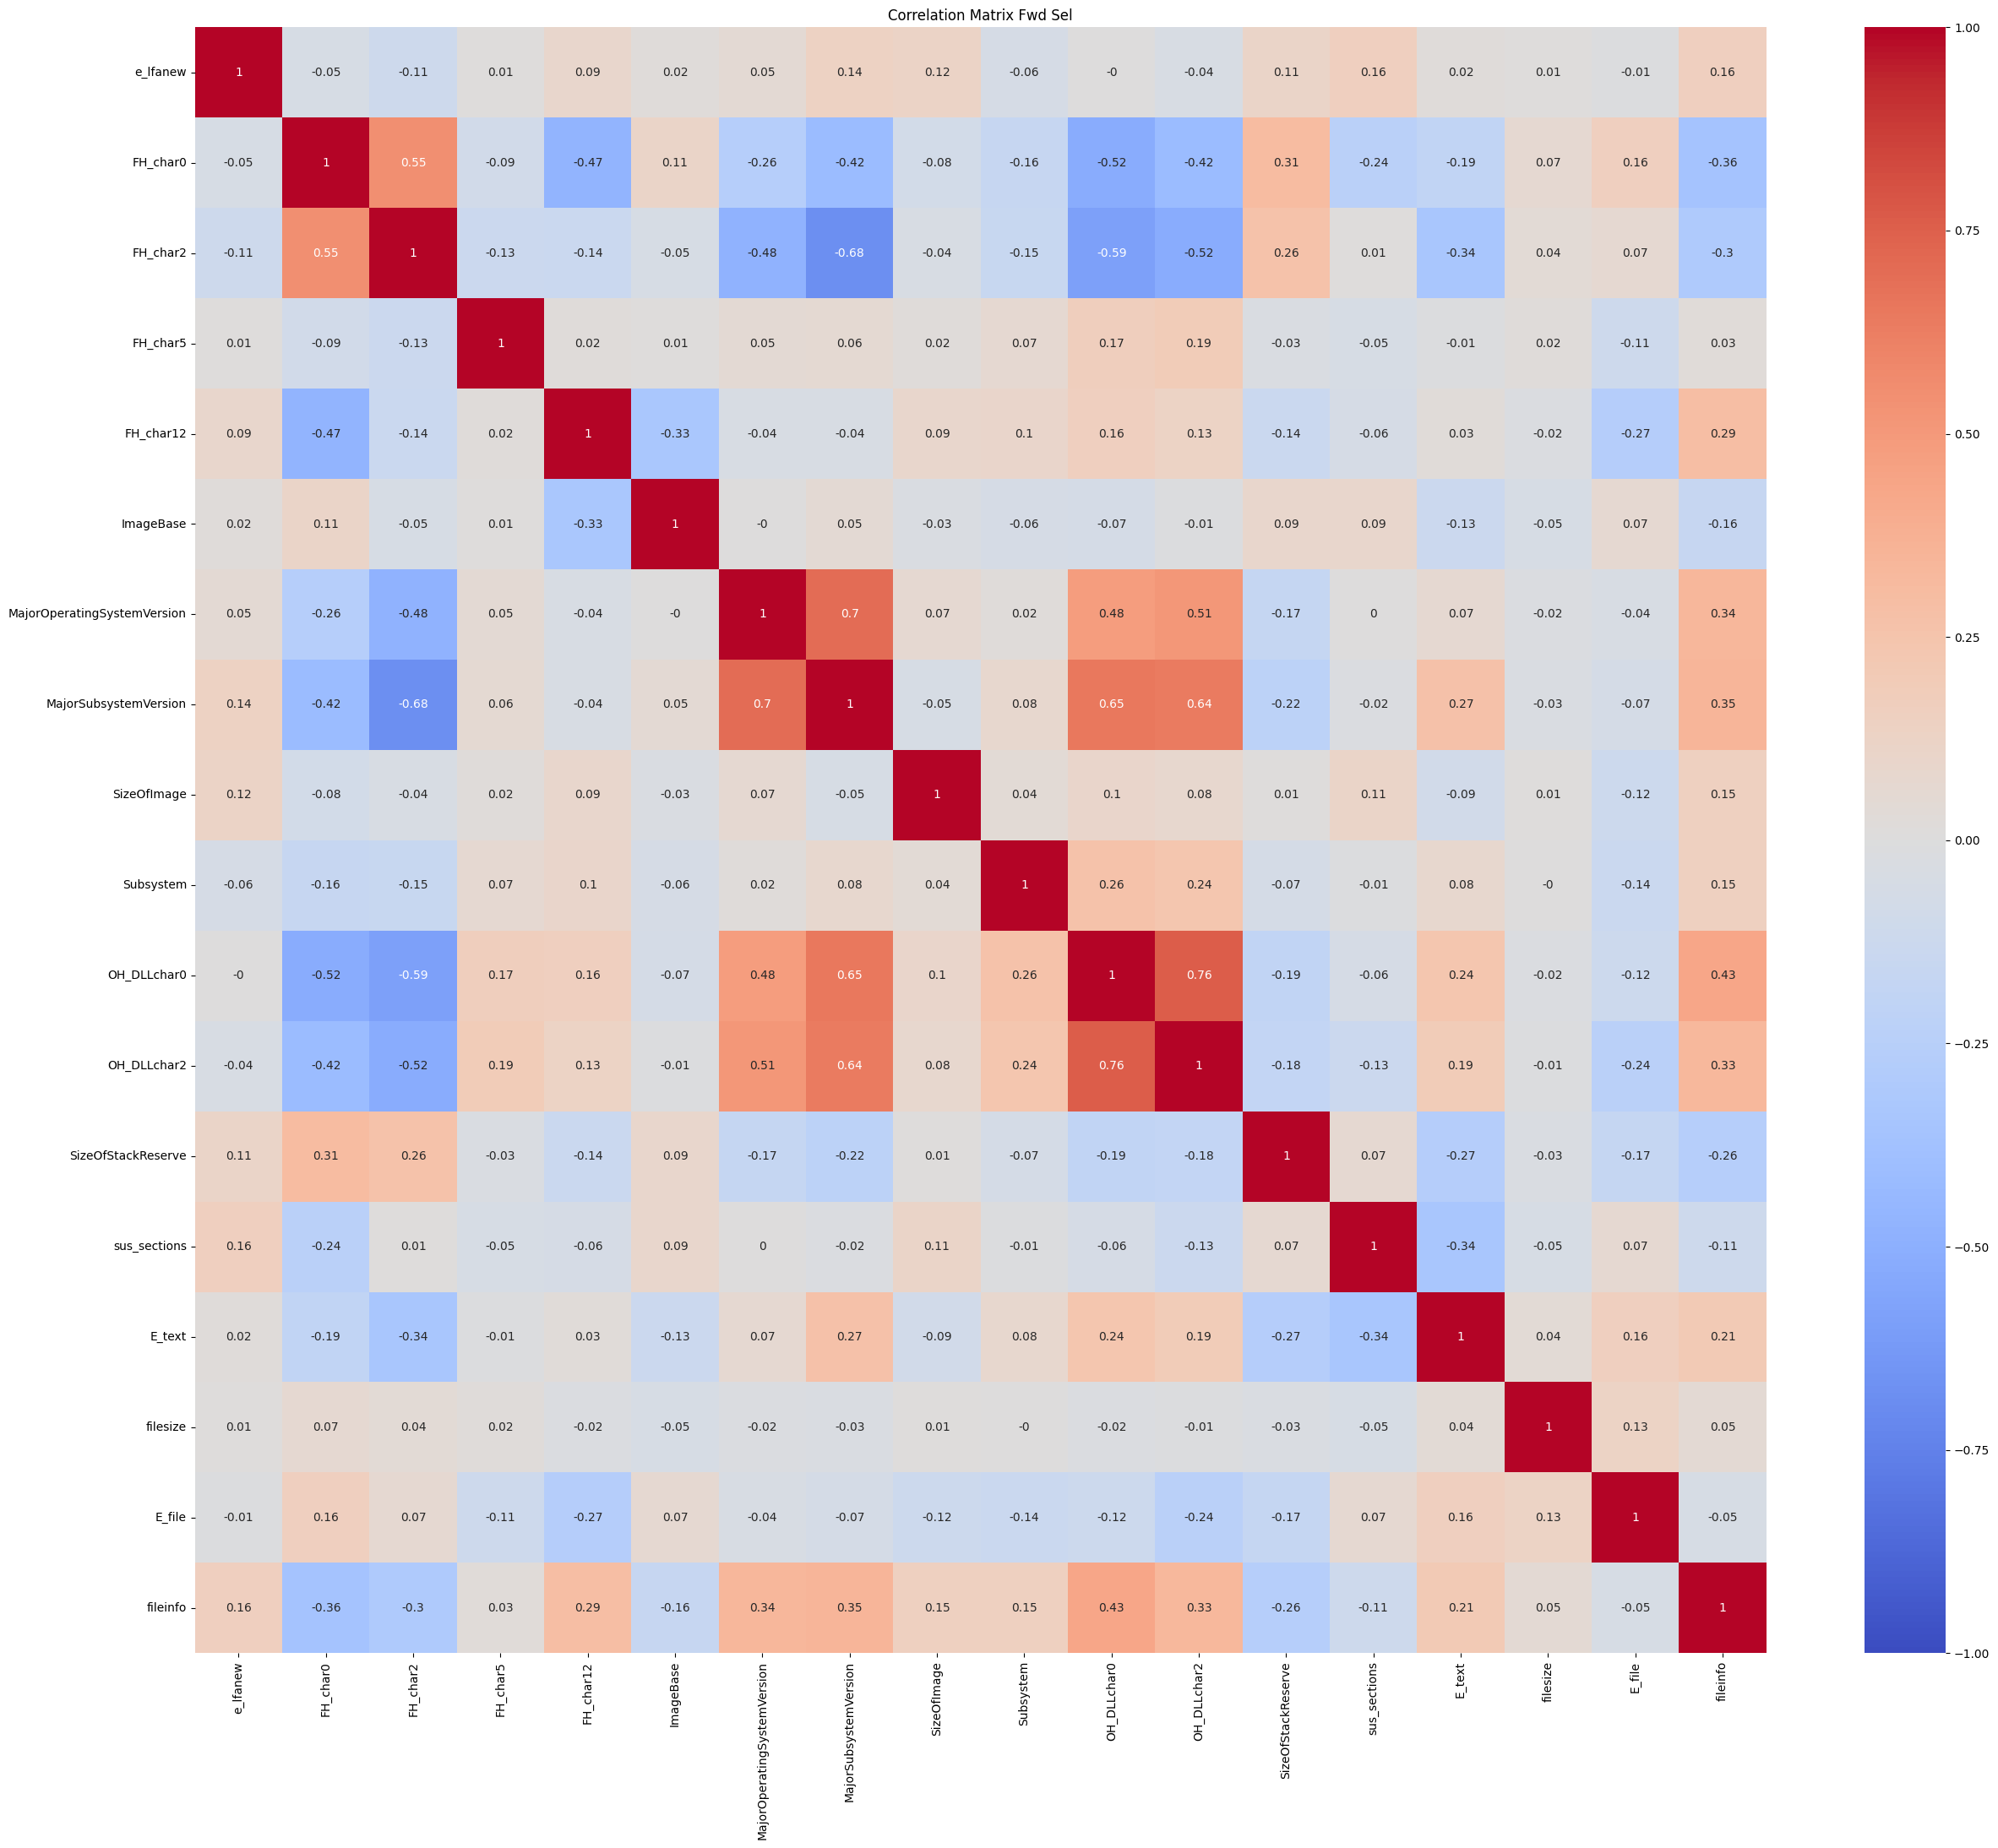

In [41]:
corr_matrix = train_x_filtered.corr(method='pearson').round(2)

plt.figure(figsize=(30,25))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Fwd Sel')
plt.show()

## 4: Processing

### 4.1: Feature Scaling

In [42]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()


# Fit the scaler on the training data and transform it
train_x_scaled = scaler.fit_transform(train_x_filtered)

# Convert the scaled data back to a DataFrame (optional, but helpful for keeping track of feature names)
train_x_scaled = pd.DataFrame(train_x_scaled, columns=train_x_filtered.columns)

test_filtered_x = test_x[train_x_filtered.columns]

test_x_scaled = scaler.transform(test_filtered_x)


The features are scaled using z-score normalization to prepare the data for processing

In [65]:
import pickle

with open('scaler.pkl','wb') as f:
    pickle.dump(scaler,f)

### 4.2: Support Vector Machine Classification

In [43]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


# Define the KNN model
svm = SVC()

param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}


# Set up GridSearchCV to find the best k with cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_x_scaled, train_y_proc)

# Extracting the results
results = pd.DataFrame(grid_search.cv_results_)

# Step 4: Extract the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best CV Score: {best_score:.4f}")

Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best CV Score: 0.9767


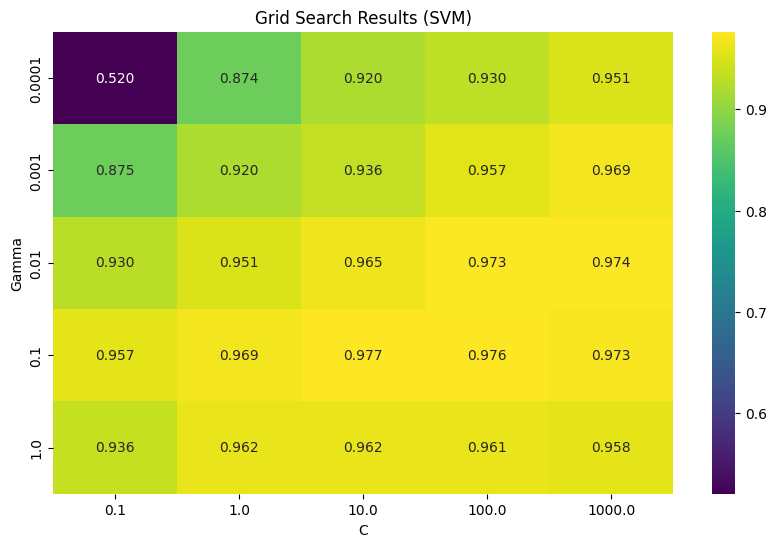

In [44]:
# Extract the parameter values and corresponding mean test scores
C_values = results['param_C'].astype(float)
gamma_values = results['param_gamma'].astype(float)
mean_test_scores = results['mean_test_score']

# Create a pivot table to arrange the results for heatmap
heatmap_data = pd.pivot_table(
    results,
    values='mean_test_score',
    index='param_gamma',
    columns='param_C'
)

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap='viridis')
plt.title('Grid Search Results (SVM)')
plt.xlabel('C')
plt.ylabel('Gamma')
plt.show()

In [45]:
# Initialize the SVM classifier
svm_classifier = SVC(kernel=best_params['kernel'], C=best_params['C'], gamma=best_params['gamma'],random_state=42)

# Train the SVM model
svm_classifier.fit(train_x_scaled, train_y_proc)

SVC(C=10, gamma=0.1, random_state=42)

### 4.3: Neural Network Classification

In [46]:
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV

# Step 1: Define the parameter grid for 'random_state'
param_grid = {
    'hidden_layer_sizes' : [(25,),(50,),(75,),(100,), (25,25),(50,25),(100,50),(100,50,25),(100,50,50,25)]
}

# Step 2: Initialize the MLPClassifier with other fixed parameters
mlp = MLPClassifier(max_iter=750, activation='relu')

# Step 3: Perform Grid Search
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(train_x_scaled, train_y_proc)

# Extracting the results
results = pd.DataFrame(grid_search.cv_results_)

# Step 4: Extract the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best CV Score: {best_score:.4f}")

Best Parameters: {'hidden_layer_sizes': (50,)}
Best CV Score: 0.9799


/tmp/ipykernel_159924/930399298.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Hidden Layer Sizes', y='Mean Test Score', data=plot_data, palette="viridis")


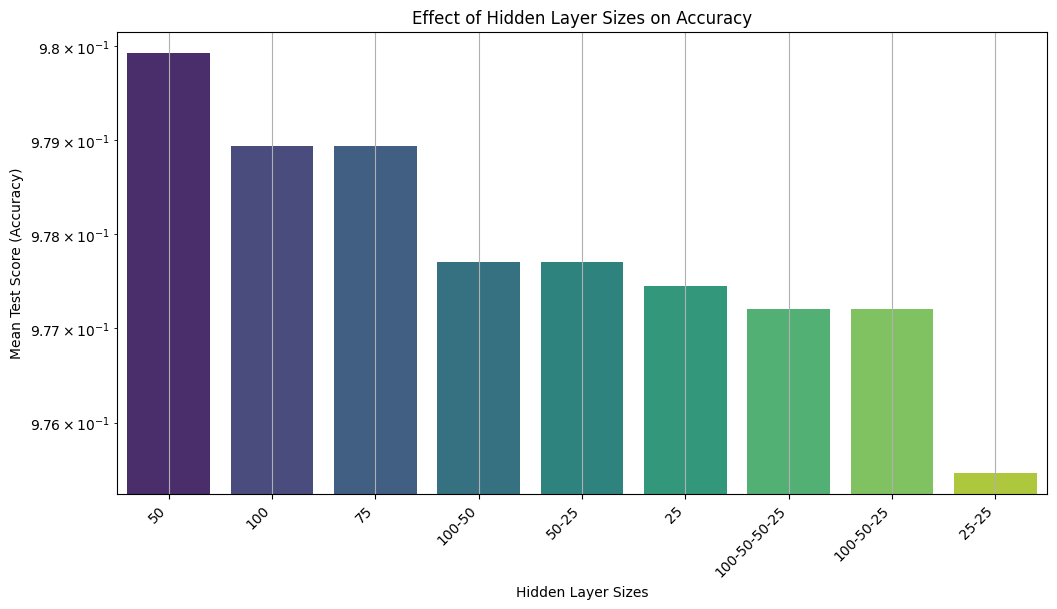

In [47]:
# Extracting the hidden layer sizes and corresponding mean test scores
hidden_layer_sizes = ['-'.join(map(str, size)) for size in results['param_hidden_layer_sizes']]
mean_test_scores = results['mean_test_score']

# Create a DataFrame for easier plotting
plot_data = pd.DataFrame({
    'Hidden Layer Sizes': hidden_layer_sizes,
    'Mean Test Score': mean_test_scores
})

# Sorting the DataFrame based on the hidden layer sizes for better visualization
plot_data = plot_data.sort_values('Mean Test Score', ascending=False)

# Plotting the results
plt.figure(figsize=(12, 6))
sns.barplot(x='Hidden Layer Sizes', y='Mean Test Score', data=plot_data, palette="viridis")

plt.yscale('log')
# Adding labels and title
plt.xlabel('Hidden Layer Sizes')
plt.ylabel('Mean Test Score (Accuracy)')
plt.title('Effect of Hidden Layer Sizes on Accuracy')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

In [48]:
mlp_best = MLPClassifier(hidden_layer_sizes=best_params['hidden_layer_sizes'],
                         max_iter=700, activation='relu')
mlp_best.fit(train_x_scaled, train_y_proc)


MLPClassifier(hidden_layer_sizes=(50,), max_iter=700)

## 5: Validation


### 5.1: SVM Validation

              precision    recall  f1-score   support

      Normal     0.9646    0.9684    0.9665       507
     Malware     0.9700    0.9664    0.9682       535

    accuracy                         0.9674      1042
   macro avg     0.9673    0.9674    0.9674      1042
weighted avg     0.9674    0.9674    0.9674      1042



/home/francescodm/Documents/Uni/AI/ai-project/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/francescodm/Documents/Uni/AI/ai-project/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


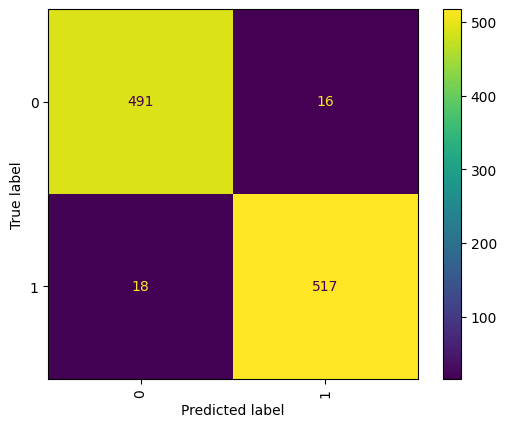

In [50]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

pred_y = svm_classifier.predict(test_x_scaled)

print(classification_report(test_y, pred_y, target_names=['Normal', 'Malware'], digits=4))

ConfusionMatrixDisplay.from_estimator(svm_classifier, test_x_scaled, test_y, xticks_rotation="vertical")

In [51]:
import pickle

with open('svm_model.pkl','wb') as f:
    pickle.dump(svm_classifier,f)

### 5.2: NN Validation

              precision    recall  f1-score   support

      Normal     0.9841    0.9744    0.9792       507
     Malware     0.9759    0.9850    0.9805       535

    accuracy                         0.9798      1042
   macro avg     0.9800    0.9797    0.9798      1042
weighted avg     0.9799    0.9798    0.9798      1042



/home/francescodm/Documents/Uni/AI/ai-project/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/francescodm/Documents/Uni/AI/ai-project/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


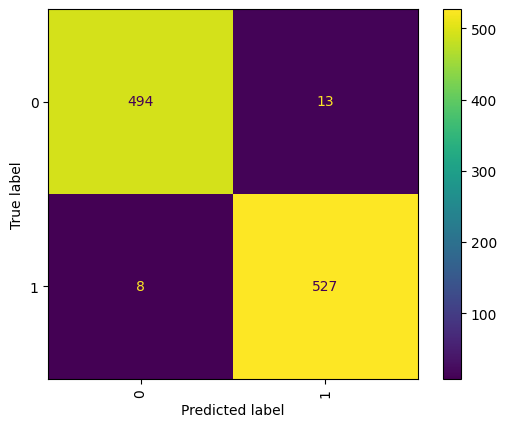

In [52]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

pred_y_mlp = mlp_best.predict(test_x_scaled)

print(classification_report(test_y, pred_y_mlp, target_names=['Normal', 'Malware'], digits=4))

ConfusionMatrixDisplay.from_estimator(mlp_best, test_x_scaled, test_y, xticks_rotation="vertical")

In [53]:
import pickle

with open('mlp_model.pkl','wb') as f:
    pickle.dump(mlp_best,f)

### Model comparison

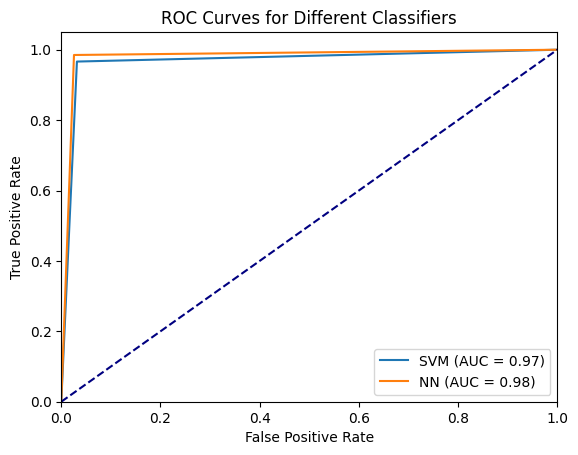

In [54]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split


fpr_svm, tpr_svm, _ = roc_curve(test_y, pred_y)
roc_auc = auc(fpr_svm, tpr_svm)
    
    # Plot the ROC curve
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc:.2f})')

fpr_mlp, tpr_mlp, _ = roc_curve(test_y, pred_y_mlp)
roc_auc = auc(fpr_mlp, tpr_mlp)
    
    # Plot the ROC curve
plt.plot(fpr_mlp, tpr_mlp, label=f'NN (AUC = {roc_auc:.2f})')

# Plot the 45-degree line (no-discrimination line)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Classifiers')
plt.legend(loc='lower right')

# Show the plot
plt.show()

## 6: Conclusions

The NN outperforms the SVM, this is probably due to the ability of Neural Networks to better identify complex feature relationships and manage noisy data.

### 7: References

1. https://www.kaggle.com/datasets/saurabhshahane/classification-of-malwares/data <div id="reference-section-1"></div>
2. https://github.com/urwithajit9/clamp <div id="reference-section-2"></div>
3.